# Supervised Learning Capstone - Kristofer Schobert

## Evaluating binary classification models to predict rain in Sydney, Australia

#### Introduction
Weather prediction is of great importance to most everyone. It can help answer some of life's simple questions like "Will I need to bring an umbrella?" as well as its more dire ones, "Do we need to evacuate?" Farmers strongly rely on weather predictions for their harvesting. Airports and other forms of transit rely on these predictions to safely transport their passengers. Careful analysis of our weather and climate can even help us predict the future of our planet. For these reasons and countless more, we seek the forcaste of tomorrow.

#### Our Task
We have obtained a dataset from Kaggle, which contains a wealth of weather data from Australia. This dataset contains 22 features, physical quantities that describe the weather during a given day in a city of Australia, and one outcome variable: whether or not it rained the next day. Our goal will be to take these 22 input variables for a given day and correctly predict if it rained the next day. We will simplify our task and only consider instances in Sydney, AUS. 

#### Our Methodology 
We will evaluate several binary classification models to determine which one is best at predicting an instance of rain tomorrow. We will use the accuracy scores of cross validation folds from our training data as our metric for success. If multiple models have similar cross validation accuracy scores, we will evaluate the recall scores of those cross validation folds and use that as a tie breaker to determine the best model. 

link to kaggle's dataset: https://www.kaggle.com/jsphyg/weather-dataset-rattle-package


Let's get started:

In [235]:
# importing all packages we will need. 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.decomposition import PCA 
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from scipy import stats
from sklearn.metrics import recall_score, make_scorer
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from matplotlib import pyplot
sns.set(style="ticks")
%matplotlib inline


In [217]:
# Importing the dataset.
df_full = pd.read_csv('weatherAUS.csv')

# We will only consider Sydney, AUS.
df_full = df_full[df_full.Location =='Sydney'].reset_index().drop('index', axis=1)

# We will exclued the column RISK_MM, which leaks information about the outcome variable. 
# This features states the amount of rain tomorrow in millimeters.

# Will will also drop 'Location'
df_full = df_full.drop(columns = ['RISK_MM', 'Location'], axis=1)
df_full.head(8)

print('Here is a list of our features:\n')
print(list(df_full.columns))

Here is a list of our features:

['Date', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow']


### Feature discussion
Tempatures are reported in degrees Celsius. The day's total rainfall is reported in millimeters. Evaporation is reported in millimeters, and it is "Class 'A' Pan Evaporation:" the amount of water that evaporates from a pan. Sunshine is the number of hours in a day with sunshine.  Wind gusts are the strongest recorded gust of the day. The speed is reported in km/hr. Humidity is reported as a percent. Pressure is the atmospheric pressure reported in hPa = 100 Pascals. Cloud coverage is measured in "oktas," how many eights of the sky is covered by clouds. Lastly, "RainToday" and "RainTomorrow" are booleans. 

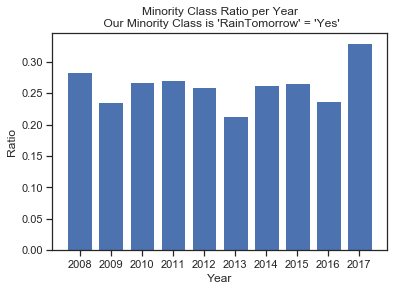

The Overall Minority Ratio is 0.25921486364998503


In [218]:
# Creating a list of the years included in our dataset
years = list(np.sort(list(set(df_full.Date.str.slice(0, 4)))))

# Creating a 'Year' column in our dataset
df_full['Year'] = df_full.Date.str.slice(0, 4)

# Calculating the overall fraction of instances with 'RainTomorrow' == 'Yes'
total_minority_fraction = df_full[df_full['RainTomorrow'] == 'Yes'].shape[0]/df_full.shape[0]

# Calculation the fraction of instances with the Minority Class per Year
year_minority_fraction = 1 - df_full.groupby('Year').describe(include='O')['RainTomorrow']['freq']/df_full.groupby('Year').describe(include='O')['RainTomorrow']['count']

# Plotting the Minority Class ratios per year
plt.bar(x = years, height = year_minority_fraction)
plt.title('Minority Class Ratio per Year\n Our Minority Class is \'RainTomorrow\' = \'Yes\'')
plt.xlabel('Year')
plt.ylabel('Ratio')
plt.show()

print('The Overall Minority Ratio is {}'.format(total_minority_fraction))

We have a minority class. Roughly a quarter of our instances have rain tomorrow. If we made a model that always predicted no rain tomorrow, we would have an accuracy score of roughly 75%. This is why we are using the recall scores of our cross validation folds as our tie-breaking metric. This three to one ratio seems to hold true for most every year. The year 2017 has a higher proportion of instances with rain tomorrow, but if we look too see how many days are reported for each year, we see that only half of 2017 was reported. This could influence this higher proportion. Maybe we have only collected instances during the rainy season in 2017.

In [219]:
df_full.groupby('Year').describe(include='O')['RainTomorrow']['count']

Year
2008    335
2009    365
2010    362
2011    335
2012    335
2013    337
2014    361
2015    365
2016    366
2017    176
Name: count, dtype: object

As we previously stated, the year 2017 has roughly half of the days included in our dataset. Also, 2008, 2011, 2012 and 2013 are missing close to 30 days in this dataset. We would like to use roughly one fifth of the data in our testing dataset. Let's use the instance from 2011 and 2014 as our testing data. This is a nice choice because it our data is now split 20:80 as we desired. One of our testing years is missing 30 days (like many years) and the other has most all 365 days. 

In [220]:
# we will name the training dataframe simply df
# we will name the testing dataframe df_test
# we will also drop the 'Year' column from the testing and training datasets
df = df_full[(df_full['Year'] != '2011') & (df_full['Year'] != '2014')].drop(['Year'], 1)
df_test = df_full[(df_full['Year'] == '2011') | (df_full['Year'] == '2014')].drop(['Year'], 1)

In [221]:
print('The ratio of our testing data to the total dataset is {}'
      .format(df_test.shape[0]/(df_test.shape[0] + df.shape[0])))

The ratio of our testing data to the total dataset is 0.20857057237039256


# Feature Selection

Let's see how many missing values we have in our full dataset (i.e. both the training and testing dataset)

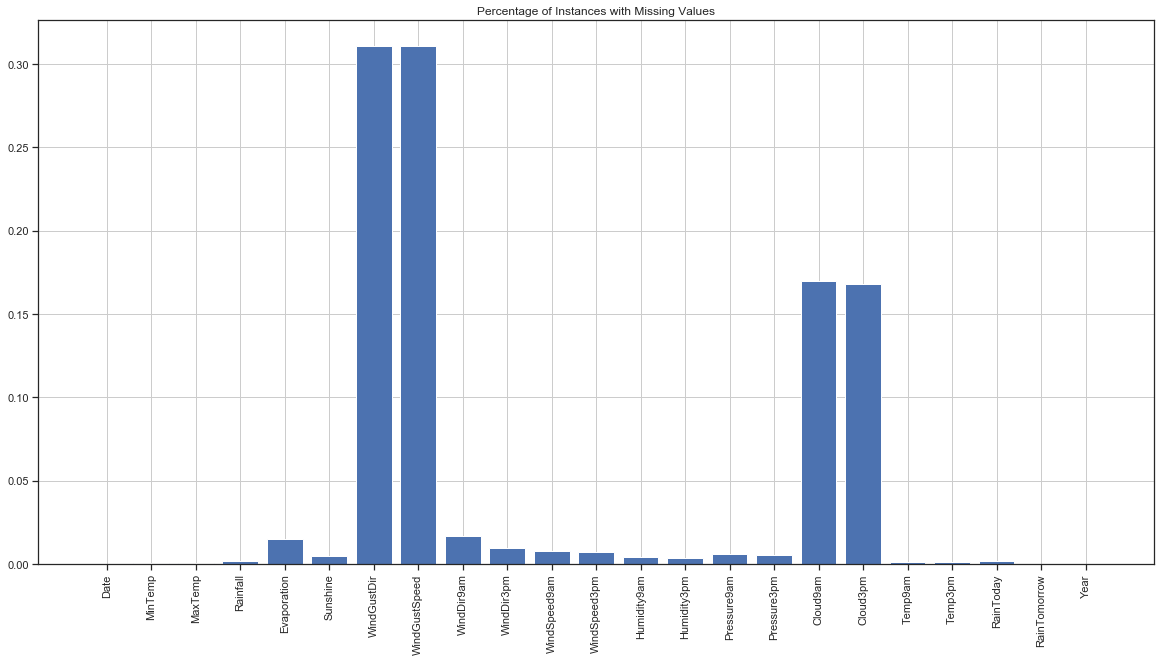

In [222]:
# plotting the number of NaN values per feature.
plt.figure(figsize=(20,10))
plt.bar(x = df_full.columns, height = list(df_full.isna().sum()/df_full.shape[0]))
plt.title('Percentage of Instances with Missing Values')
plt.xticks(rotation=90)
plt.grid(b=True)
plt.show()

# increase size of the title and values on the axis. 
# do we want to keep the grey lines inside the plot?
# should we be using sns strictly?
# change the x ticks (names of the features) to look as they did on my olympics plot


From this figure, we see that 'WindGustDir' and 'WindGustSpeed' are missing values in roughly one third of our instances. In order to execute our models, we will need to drop every instance with a missing value. Thus if we include these two features, we will have to drop one third of our data. Let's choose to drop these two features instead. 

Let's see how well correlated our features are with eachother. Will will only consider the training data here. 

NOTE: We will not use the testing data until the very end of our model evaluation process. 

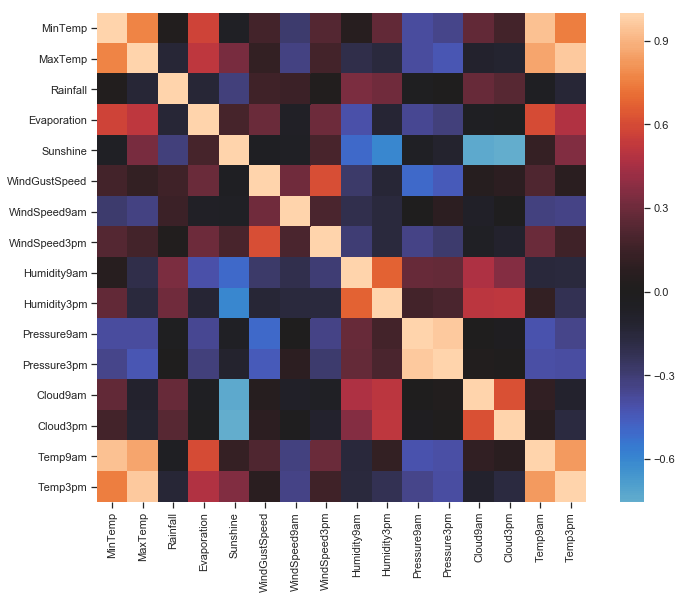

In [223]:
# Make the correlation matrix.
corrmat = df.corr()
# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(12, 9))
# Create the heatmap using seaborn.
sns.heatmap(corrmat, vmax=1, square=True, center=0)
plt.show()

This correlation matrix is very informative for our feature selection. We see that 'Cloud9am' and 'Cloud3pm' are both strongly negatively correlated with 'Sunshine'. This intuitively makes sense. Also, both 'Cloud9am' and 'Cloud3pm' have missing values in roughly one sixth of the instances. Let's remove these two features. This allows us to keep that one sixth of the data. Most of the information we would gain from including these two features should be captured by 'Sunshine'.

It is worth noting that pairs of features, which describe physical quantities at 9am vs 3pm, are well coorelated with eachother. Thus, we may want to consider removing one of the features in these pairs when we begin modeling. 

Let's drop 'Location' since we are only interested in Sydney, Austrailia. 

Let's drop 'Date' and replace it with 'Month'. The month of the year seems helpful for determining if it will rain the next day. 

In [224]:
# Let's drop these features.
# We will also drop 'Date' and Replace it with 'Month'
df['Month'] = pd.to_numeric(df.Date.str.slice(5, 7))
df = df.drop(['WindGustSpeed','WindGustDir','Cloud9am', 'Cloud3pm', 'Date'], axis=1)

df_test['Month'] = pd.to_numeric(df_test.Date.str.slice(5, 7))
df_test = df_test.drop(['WindGustSpeed','WindGustDir','Cloud9am', 'Cloud3pm', 'Date'], axis=1)

In [225]:
df.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month
0,19.5,22.4,15.6,6.2,0.0,S,SSW,17.0,20.0,92.0,84.0,1017.6,1017.4,20.7,20.9,Yes,Yes,2
1,19.5,25.6,6.0,3.4,2.7,W,E,9.0,13.0,83.0,73.0,1017.9,1016.4,22.4,24.8,Yes,Yes,2
2,21.6,24.5,6.6,2.4,0.1,ESE,ESE,17.0,2.0,88.0,86.0,1016.7,1015.6,23.5,23.0,Yes,Yes,2
3,20.2,22.8,18.8,2.2,0.0,NNE,E,22.0,20.0,83.0,90.0,1014.2,1011.8,21.4,20.9,Yes,Yes,2
4,19.7,25.7,77.4,NaN,0.0,NNE,W,11.0,6.0,88.0,74.0,1008.3,1004.8,22.5,25.5,Yes,Yes,2


Let's see how each of these features correlates with our outcome variable, 'RainTomorrow'. Note that 'RainTomorrow' was not included in our correlation table because it is not a continuous variable. 

We will do this by observing violin plots of each of our continuous features during instances with 'RainTomorrow' being true and 'RainTomorrow' being false. 

/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


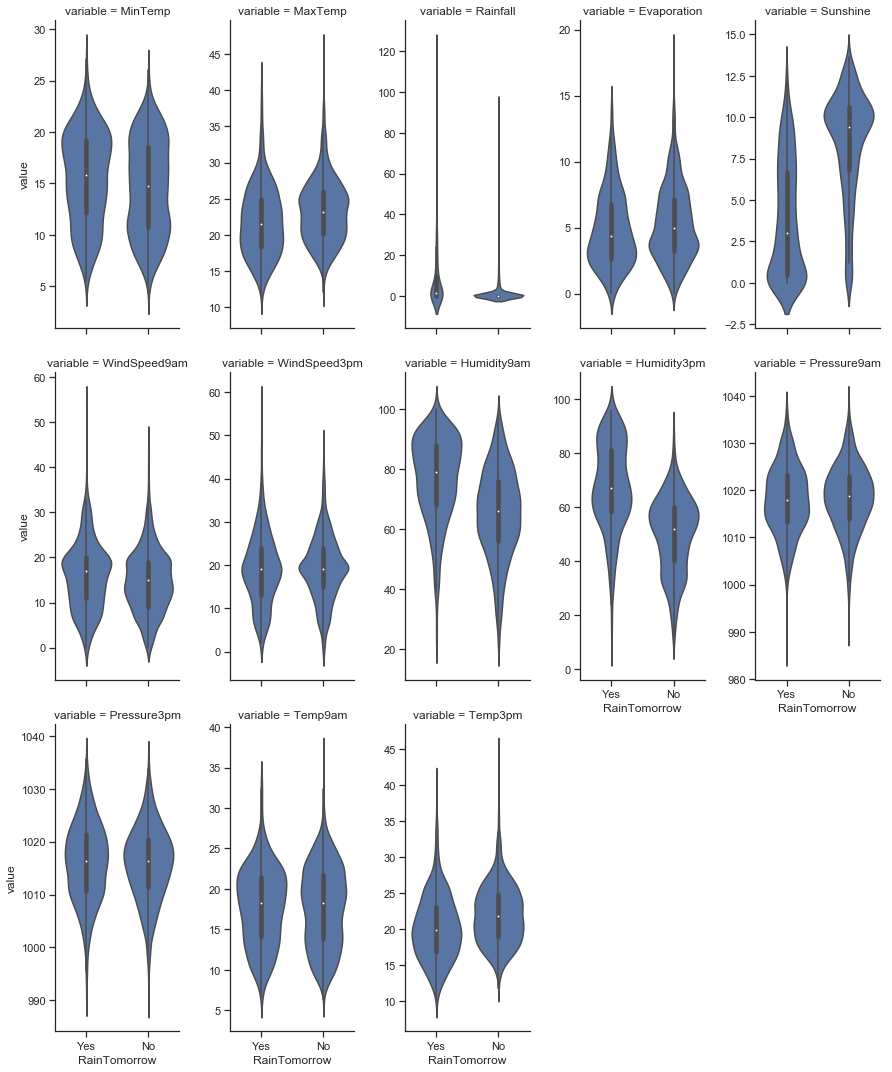

In [226]:
# Creating a dataframe composed of the training data, but excluding features that are not continuous.

df_continuous_compare_rain_tomorrow = df.drop(['WindDir9am', 'WindDir3pm', 'RainToday', 'Month'], axis=1)
df_continuous_compare_rain_tomorrow  = pd.melt(df_continuous_compare_rain_tomorrow , id_vars=['RainTomorrow'])
g = sns.FacetGrid(df_continuous_compare_rain_tomorrow, col="variable", size=5, aspect=.5, col_wrap=5, sharey=False)
g = g.map(sns.violinplot, "RainTomorrow", "value")
plt.show()

Here, we see two violin plots for every continuous feature. The one on the left shows the distribution of that feature's values during instances with rain the next day, and the one on the right shows the distributions values for that feature during days when there was no rain the next day. 

As we can see, some variables are strongly correlated with 'RainTomorrow'. The feature 'Sunshine' is highly correlated. An instance of 'RainTomorrow' most likely has a low value for 'Sunshine' and vice versa. 

Some features' distributions are roughly the same regardless if there will be rain the next day. For example, 'WindSpeed3pm' has very similar distributions.  

The difference between the median values (the white dot in the violin plots) for 'MaxTemp' and 'MinTemp' when we do not have rain tomorrow is larger than the difference in their medians when we do have rain tomorrow. This hints that a feature which captures the range of temperature in a given day may be useful. Let's create that feature. 

In [227]:
df['TempRange'] = df['MaxTemp'] - df['MinTemp']
df_test['TempRange'] = df_test['MaxTemp'] - df_test['MinTemp']

Let's see how our categorical variables relate to our outcome variable. We will plot all categories of these feature seperately and observe how many instances of rain tomorrow that category appeared in and how many instances of no rain tomorrow that category appeared in.  

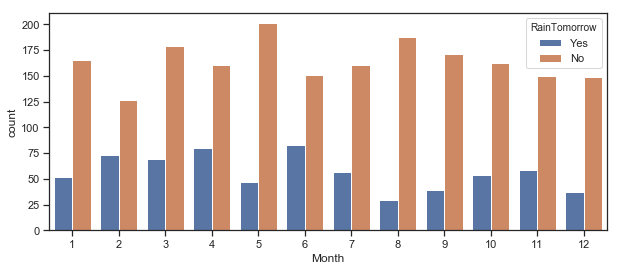

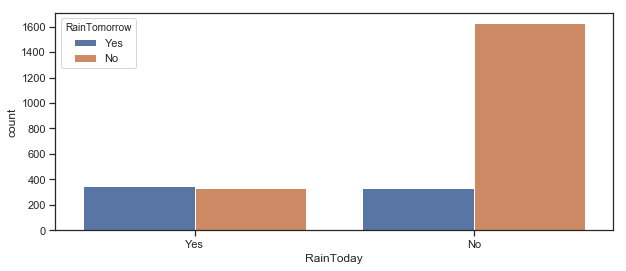

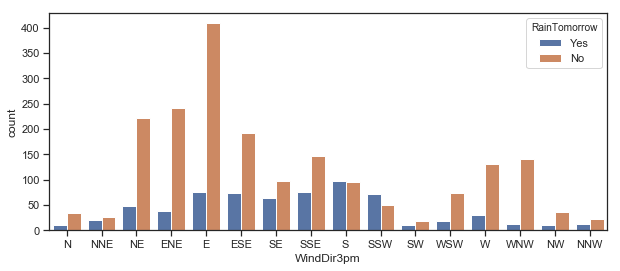

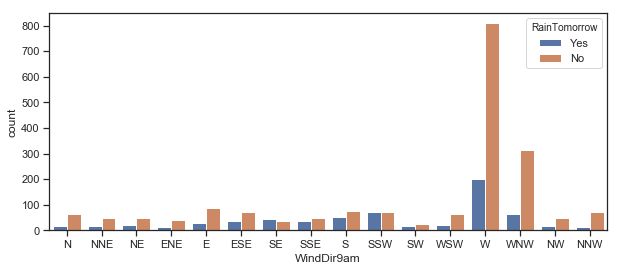

In [228]:
# Establishing figure size
plt.figure(figsize=(10,4))
df_categorical = df[['RainToday', 'Month', 'WindDir3pm', 'WindDir9am', 'RainTomorrow']]
 

directions_order = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 
                    'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']
# Plotting each categorical variable. 
g1 = sns.countplot(x="Month", hue='RainTomorrow', data=df_categorical)
plt.show()
plt.figure(figsize=(10,4))
g2 = sns.countplot(x="RainToday", hue='RainTomorrow', data=df_categorical)
plt.show()
plt.figure(figsize=(10,4))
g3 = sns.countplot(x='WindDir3pm', hue='RainTomorrow', order=directions_order,  data=df_categorical)
plt.show()
plt.figure(figsize=(10,4))
g4 = sns.countplot(x='WindDir9am', hue='RainTomorrow', order=directions_order, data=df_categorical)
plt.show()


We can think of these pairs of blue and orange bars as the weights of a weighted coin flip. For example, if it is the month of May we can flip our weighted coin to predict if it will rain tomorrow. This coin has a weight ratio of four to one. Thus, our coin will predict no rain tomorrow four fifths of the time and predict rain tomorrow the other fifth.  
Regardless of which month it is, it will always be more likely to not rain the next day. February and June look to be the months with the most instances of rain tomorrow. The ratio here is roughly one to two. Our "February coin" will predict no rain tomorrow twice as often as it will predict rain tomorrow. 

The plot for 'RainToday' informs us that if it is not raining today, it will most likely not rain tomorrow. The ratio here is about one to five. However, if it is raining today, it is slightly more likely to rain tomorrow. Thus, the forcaste is most likely to stay the same tomorrow. This is very interesting. Changing forcastes are less likely than continuing with the same rain forcaste. 

Most all directions of wind at 3pm yield no rain tomorrow as the more probable outcome, except for South and South-South-West. If the wind is blowing in either of these two directions, we will have rain tomorrow more often than not. If the wind is blowing South-East or South-South-West at 9am, we will more likely have rain tomorrow. However, the wind rarely blows in these directions at 9am as we can see from this plot. The wind most likely blows West at 9am and East at 3pm. We can see this from the heights of the bars in these plots.

### Preparing our dataset for modeling

In [229]:
# Creating dataset for modeling
# Dropping NaN values
df = df.dropna()
df_test = df_test.dropna()

# Converting the entries of 'Month' to a string, which will assist us to treating this as a catagorical variable. 
df['Month'] = df['Month'].astype('str')
df_test['Month'] = df_test['Month'].astype('str')

# We will use get_dummies to create a column for each unique value of a categorical variable. 
df = pd.get_dummies(df)
df_test = pd.get_dummies(df_test)

# 'RainToday_Yes' and 'RainTomorrow_Yes' are 1 for an instance of rain and 0 for an instance of no rain. 
# This is percisely what we want. Let's rename them simply 'RainToday' and 'RainTomorrow'. 
# We will drop 'RainTomorrow_No' and 'RainToday_No'
df = df.rename(index=str, columns={'RainToday_Yes': 'RainToday', 'RainTomorrow_Yes': 'RainTomorrow'})
df = df.drop(['RainTomorrow_No', 'RainToday_No'], axis=1)

df_test = df_test.rename(index=str, columns={'RainToday_Yes': 'RainToday', 'RainTomorrow_Yes': 'RainTomorrow'})
df_test = df_test.drop(['RainTomorrow_No', 'RainToday_No'], axis=1)

We now have many more columns. We have one column for each catagory of each categorical variable. The values in these columns are zeros (instances where the category is not occuring) and ones (instances where that category is occuring).

In [230]:
#listing all of the features of our training data. 
print(df.columns)

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm', 'TempRange',
       'WindDir9am_E', 'WindDir9am_ENE', 'WindDir9am_ESE', 'WindDir9am_N',
       'WindDir9am_NE', 'WindDir9am_NNE', 'WindDir9am_NNW', 'WindDir9am_NW',
       'WindDir9am_S', 'WindDir9am_SE', 'WindDir9am_SSE', 'WindDir9am_SSW',
       'WindDir9am_SW', 'WindDir9am_W', 'WindDir9am_WNW', 'WindDir9am_WSW',
       'WindDir3pm_E', 'WindDir3pm_ENE', 'WindDir3pm_ESE', 'WindDir3pm_N',
       'WindDir3pm_NE', 'WindDir3pm_NNE', 'WindDir3pm_NNW', 'WindDir3pm_NW',
       'WindDir3pm_S', 'WindDir3pm_SE', 'WindDir3pm_SSE', 'WindDir3pm_SSW',
       'WindDir3pm_SW', 'WindDir3pm_W', 'WindDir3pm_WNW', 'WindDir3pm_WSW',
       'RainToday', 'RainTomorrow', 'Month_1', 'Month_10', 'Month_11',
       'Month_12', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
       'Month_7', 'Month_8', 'Month_9'

This may be more columns than we need. Let's call this dataframe df_all, and create a dataframe with less features. We will see how well each feature correlates with the outcome variable. Those that have a stronger correlation we will keep. 

In [231]:
# Let's name the data frames will All of the features df_all and df_all_test.
df_all = df.copy()
df_all_test = df_test.copy()

In [232]:
cutoff = .12
significant_features = []
for feature in df.columns:
    if abs(df.corr()['RainTomorrow'][feature]) > cutoff:
        significant_features.append(feature)
        
print(significant_features)        

['MaxTemp', 'Rainfall', 'Sunshine', 'Humidity9am', 'Humidity3pm', 'Temp3pm', 'TempRange', 'WindDir9am_SSW', 'WindDir3pm_S', 'WindDir3pm_SSW', 'RainToday', 'RainTomorrow']


We will now create a training and testing dataframe with only the "significant features." These are the features that have a correlation coefficient greater than 0.12 in magnitude with the outcome variable. 

In [233]:
df_sign = df[significant_features].copy()
df_sign_test = df_test[significant_features].copy()

We will also have a third dataset which employ Principal Component Analysis. We will use the 5 principal components of the training dataset. 

In [234]:
# engadging PCA
sklearn_pca = PCA(n_components=5)

# fitting the model with the training dataset with all the features
sklearn_pca.fit(df_all.drop('RainTomorrow', 1))

# trainforming the training dataset with all the features
df_pca = sklearn_pca.transform(df_all.drop('RainTomorrow', 1))

# trainforming the testing dataset with all the features
df_pca_test = sklearn_pca.transform(df_all_test.drop('RainTomorrow', 1))


Now we have the three dataframes that we will use throughout the model evaluation process, and three to use once we have found our best model.

Training: df_all, 
df_sign,
df_pca

Testing: df_all_test,
df_sign_test,
df_pca_test


# Nearest Neighbors

We will first need a function that will output two plots given the specifics of our model. One showing the accuracy scores of our cross validation folds versus a model parameter, and another showing the recall scores of the cross validation folds versus a model parameter. 

We will then try many combinations of parameters and features to see which is best. Also, we will scale all the features to have a mean of zero and unit varience.

In [239]:


def knn_plot_cvs_recall(x, params, values, using):
 
    """ 
    Takes in four parameters and outputs two plots related to the KNN model. One of cross validation 
    accuracy scores vs number of neighbors considered, and the other showing the recall scores vs the number 
    of neighbors. 

    x: the dataframe of input features
    params: the parameters other than n_estimators for the KNN model
    values: a list of values for n_neighbors to be equal to 
    using: a portion of the title of the plots usually begining with the word "Using"

    returns: a plot of cross validation accuracy scores vs number of estimators with errorbars,
    and a plot of cross validation recall scores vs number of neighbors with errorbars

    """

    # Initializing lists containing the mean and uncertainty in the accuracy and recall scores.
    mean_scores = []
    sigma2_scores = []
    mean_recalls = []
    sigma2_recalls = []
    recall = make_scorer(recall_score)
    
    # the target
    Y = df_all['RainTomorrow']
    
    # Looping through all values of n_neighbors and recording cross validation statistics.
    for value in values: 
        neighbors = KNeighborsClassifier(n_neighbors=value, **params)
        cross_score = cross_val_score(neighbors, x, Y, cv=10)
        mean_scores.append(cross_score.mean())
        sigma2_scores.append(cross_score.std() * 2)

        recall_ = cross_val_score(neighbors, x, Y, cv=10, scoring=recall)
        mean_recalls.append(recall_.mean())
        sigma2_recalls.append(recall_.std() * 2)

    # Plotting the two figures.    
    plt.figure(figsize=(15,5))

    plt.subplot(1, 2, 1)
    plt.errorbar(values, mean_scores, yerr = sigma2_scores, capsize=6)
    plt.title('Cross Validation Accuracy Score vs Number of Nearest Neighbors\n' + str(using))
    plt.xlabel('Number of Nearest Neighbors')
    plt.ylabel('Cross Validation Accuracy Score')

    plt.subplot(1, 2, 2)    
    plt.errorbar(values, mean_recalls, yerr = sigma2_recalls, capsize=6, color='coral')
    plt.title('Cross Validation Recall Score vs Number of Nearest Neighbors\n' + str(using))
    plt.xlabel('Number of Nearest Neighbors')
    plt.ylabel('Cross Validation Recall Score')
    plt.show()
    
    # Printing the maximum mean accuracy score
    print('The maximum mean cross validation accuracy score is ' + str(max(mean_scores)))


### KNN using all features

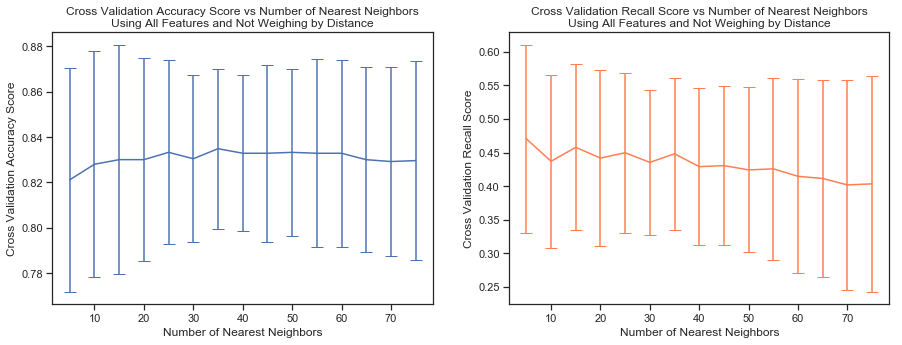

The maximum mean cross validation accuracy score is 0.834888010970354


In [240]:
# scaling our features to have a mean of zero and unit varience.
X_unscaled = df_all.drop(['RainTomorrow'], axis=1)
X = preprocessing.scale(X_unscaled, axis=1)
# no extra parameters (like weights='distance') this round. 
params = {}
# the various number of nearest neighbors our model will use
values = [i for i in range(5,80,5)]
# part of our plot titles
using = 'Using All Features and Not Weighing by Distance'
knn_plot_cvs_recall(X, params, values, using)


We see that using at least 35 nearest neighbors is effective. A cross validation score of roughly 83.5% is achieved. If we use too many nearest neightbors our recall scores decrease. Let's stick with 35 neighbors for this model. 

Now, let's see what we have when we weigh a neighbor's influence by the distance to the point in question. 

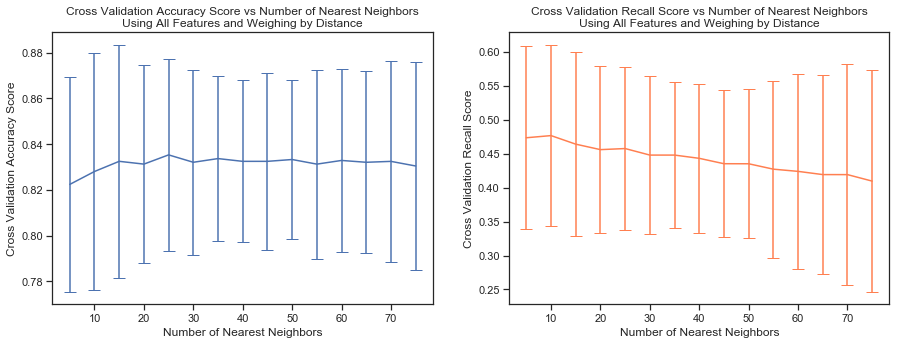

The maximum mean cross validation accuracy score is 0.8352945017630926


In [90]:
X_unscaled = df_all.drop(['RainTomorrow'], axis=1)
X = preprocessing.scale(X_unscaled, axis=1)
params = {'weights' : 'distance'}
values = [i for i in range(5,80,5)]
using = 'Using All Features and Weighing by Distance'
knn_plot_cvs_recall(X, params, values, using)


This looks similar. However, we see a small increase in our accuracy score around 25 neighbors. Also our recall curve is smoother with the weight applied. Let's now use this model with 25 neighbors as our best KNN. There is also a nice small boost in our recall score when we have 25 neighbors. 

Now, let's use only the significant features. Again these significant features are features that correlate most with our outcome variable. 

### KNN Significant Features Only 

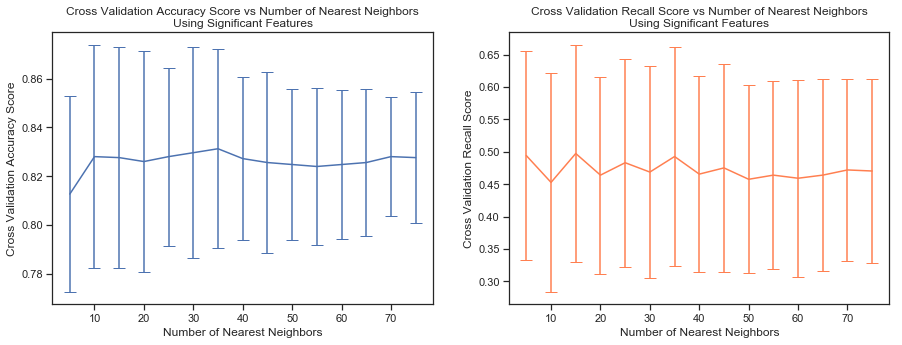

The maximum mean cross validation accuracy score is 0.8312475512602846


In [91]:
X_unscaled = df_sign.drop(['RainTomorrow'], axis=1)
X = preprocessing.scale(X_unscaled, axis=1)
params = {}
values = [i for i in range(5,80,5)]
using = 'Using Significant Features'
knn_plot_cvs_recall(X, params, values, using)

The maximum accuracy score is slightly less than our previous maximum. It is only 0.4% worse relative to a 4% errorbar. The errorbars are two standard deviations from the mean. Thus, this small difference is insignificant. However, we have an increase in recall by roughly 5% relative to a 15% errorbar. This is a third of an errorbar increase versus a tenth of an errorbar decrease. Let's allow this new model to be our winner. It is extremely similar in its accuracy but a little better at recall. 


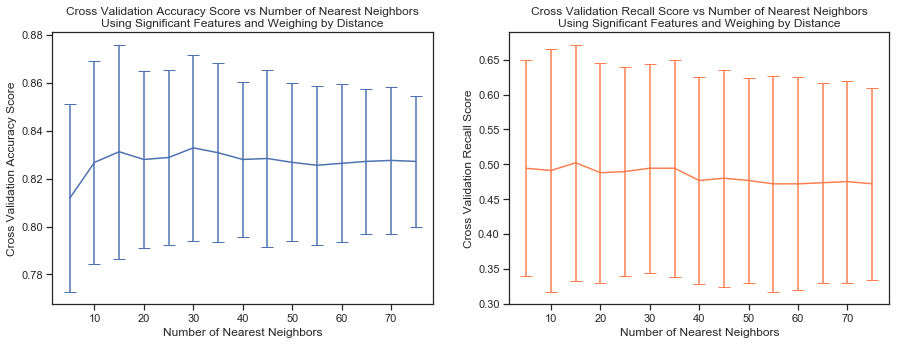

The maximum mean cross validation accuracy score is 0.8328620869792347


In [94]:
X_unscaled = df_sign.drop(['RainTomorrow'], axis=1)
X = preprocessing.scale(X_unscaled, axis=1)
params = {'weights':'distance'}
values = [i for i in range(5,80,5)]
using = 'Using Significant Features and Weighing by Distance'
knn_plot_cvs_recall(X, params, values, using)

With 30 neighbors, this is even a little better in both accuracy and recall. Let's use this as our winner for now.

Now, we try our dataframe that contains the 5 principle components of df_all's features.

### KNN with PCA

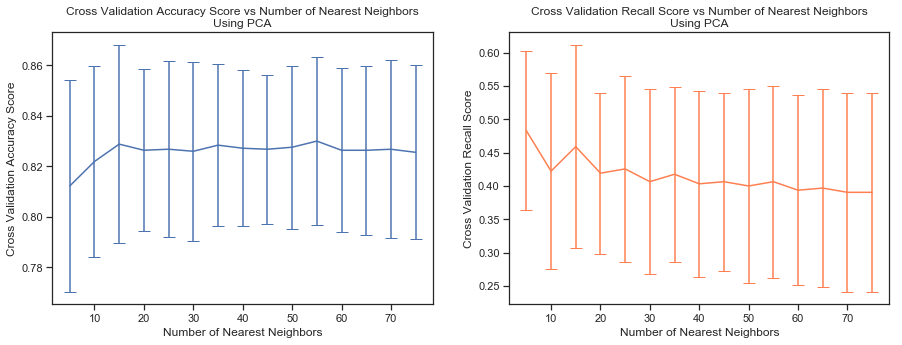

The maximum mean cross validation accuracy score is 0.8300329763614993


In [97]:
X = df_pca
params = {}
values = [i for i in range(5,80,5)]
using = 'Using PCA'
knn_plot_cvs_recall(X, params, values, using)

This is noticably worse. This is the lowest maximum accuracy score we have seen. 

Will weighing by distance help?

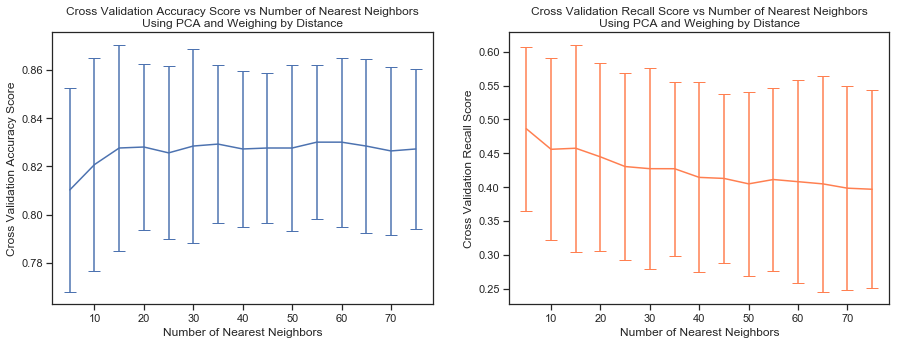

The maximum mean cross validation accuracy score is 0.8300346088546429


In [99]:
X = df_pca
params = {'weights':'distance'}
values = [i for i in range(5,80,5)]
using = 'Using PCA and Weighing by Distance'
knn_plot_cvs_recall(X, params, values, using)

It did not help much at all. 

## KNN Winning Model

We have a winner: Using significant features scaled, weighing by distance, and using 30 neighbors. 

# Random Forest

Now, we will impliment the same process with Random Forests.

Let's make our function we will run in each trial of the model. It is very similar to KNN's plotting function.

In [24]:
def rf_plot_cvs_recall(x, params, values, using):
 
    """ 
    Takes in four parameters and outputs two plots related to the Random Forest model. One of cross validation 
    accuracy scores vs number of estimators, and the other showing the recall scores vs the number 
    of estimators. 

    x: the dataframe of input features
    params: the parameters other than n_estimators for the Random Forest model
    values: a list of values for n_estimators to be equal to 
    using: a portion of the title of the plots usually begining with the word "Using"

    returns: a plot of cross validation accuracy scores vs number of estimators with errorbars,
    and a plot of cross validation recall scores vs number of estimators with errorbars

    """
    
    # see the KNN plotting funtion for details on this code. It is near identical.
    
    mean_scores = []
    sigma2_scores = []
    mean_recalls = []
    sigma2_recalls = []
    recall = make_scorer(recall_score)
    
    Y = df_all['RainTomorrow']
    
    for value in values: 
        rfc = ensemble.RandomForestClassifier(n_estimators=value, **params)
        cross_score = cross_val_score(rfc, x, Y, cv=10)
        mean_scores.append(cross_score.mean())
        sigma2_scores.append(cross_score.std() * 2)

        recall_ = cross_val_score(rfc, x, Y, cv=10, scoring=recall)
        mean_recalls.append(recall_.mean())
        sigma2_recalls.append(recall_.std() * 2)

    plt.figure(figsize=(15,5))

    plt.subplot(1, 2, 1)
    plt.errorbar(values, mean_scores, yerr = sigma2_scores, capsize=6)
    plt.title('Cross Validation Accuracy Score vs Number of Estimators\n' + str(using))
    plt.xlabel('Number of Estimators')
    plt.ylabel('Cross Validation Accuracy Score')

    plt.subplot(1, 2, 2)    
    plt.errorbar(values, mean_recalls, yerr = sigma2_recalls, capsize=6, color='coral')
    plt.title('Cross Validation Recall Score vs Number of Estimators\n' + str(using))
    plt.xlabel('Number of Estimators')
    plt.ylabel('Cross Validation Recall Score')
    plt.show()
    
    print('The maximum mean cross validation accuracy score is ' + str(max(mean_scores)))


### We will vary: 
Features, branching criterion and number of estimators.

### Random Forest Using All Features

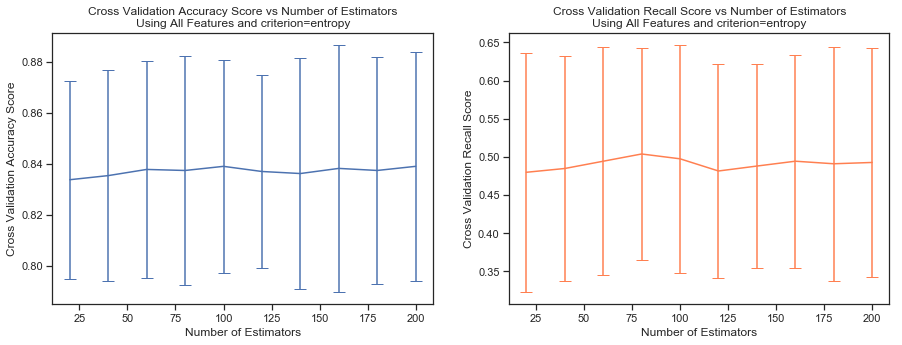

The maximum mean cross validation accuracy score is 0.8389170040485829


In [130]:
# all features, criterion = entropy

X = df_all.drop(['RainTomorrow'], axis=1)
params = {'criterion':'entropy'}
values = [i for i in range(20,201,20)]
using = 'Using All Features and criterion=entropy'
rf_plot_cvs_recall(X, params, values, using)

The number of estimators does not seem to have a significant effect on the accuracy or recall scores of the cross validation folds. We have a slightly higher accuracy and recall score than we did using KNN. Let's try using gini impurity as the criterion for splitting.

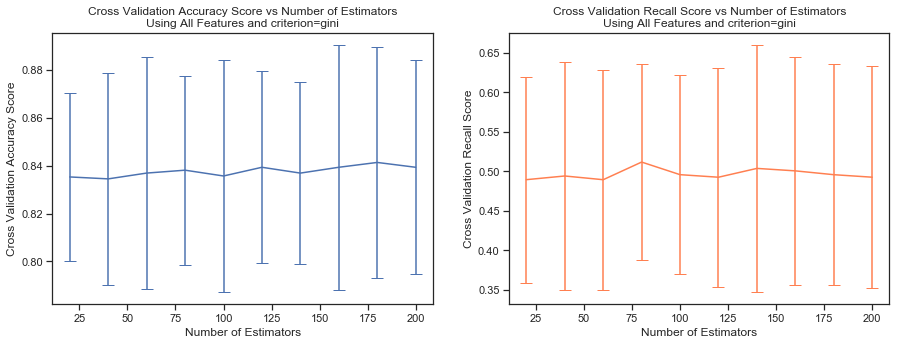

The maximum mean cross validation accuracy score is 0.8413396238735797


In [138]:
# all features, criterion = gini

X = df_all.drop(['RainTomorrow'], axis=1)
params = {'criterion':'gini'}
values = [i for i in range(20,201,20)]
using = 'Using All Features and criterion=gini'
rf_plot_cvs_recall(X, params, values, using)

Our cross validation accuracy score is even a little better here. Let's try with only the significant features.

### Random Forest Using Significant Features

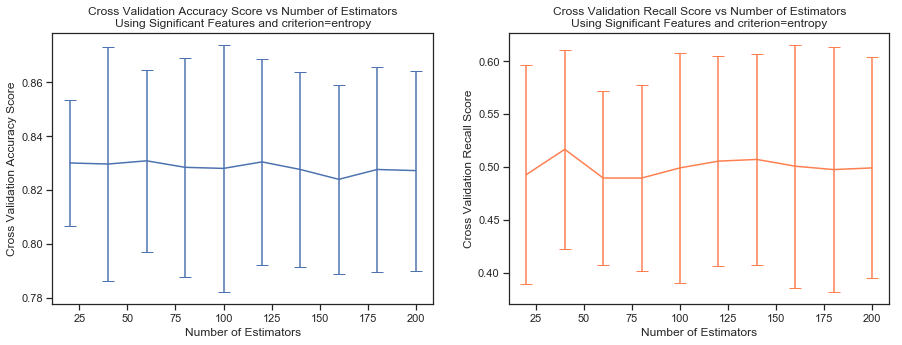

The maximum mean cross validation accuracy score is 0.8308394279744025


In [25]:
# significant features, criterion = entropy

X = df_sign.drop(['RainTomorrow'], axis=1)
params = {'criterion':'entropy'}
values = [i for i in range(20,201,20)]
using = 'Using Significant Features and criterion=entropy'
rf_plot_cvs_recall(X, params, values, using)

This cross validation accuracy score is not as high as with all features. Let's try a different branching criterion.

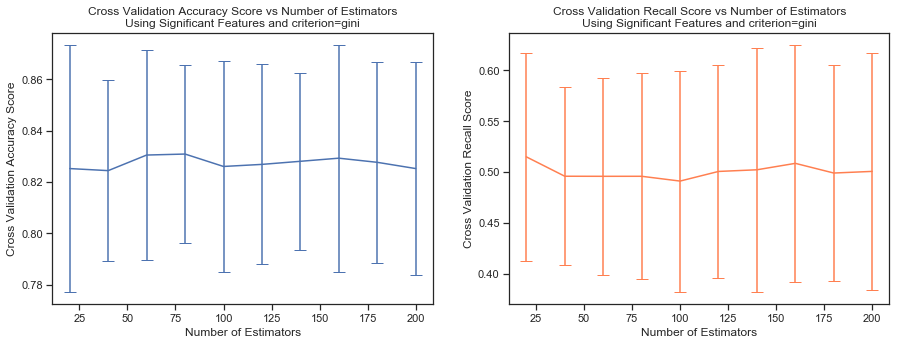

The maximum mean cross validation accuracy score is 0.830841060467546


In [133]:
# significant features, criterion = gini

X = df_sign.drop(['RainTomorrow'], axis=1)
params = {'criterion':'gini'}
values = [i for i in range(20,201,20)]
using = 'Using Significant Features and criterion=gini'
rf_plot_cvs_recall(X, params, values, using)

No, this is still not better. The cross validation accuracy score is lower here than it was with all features. Maybe using pricipal components will beat our current winner. 

## Random Forests Using PCA

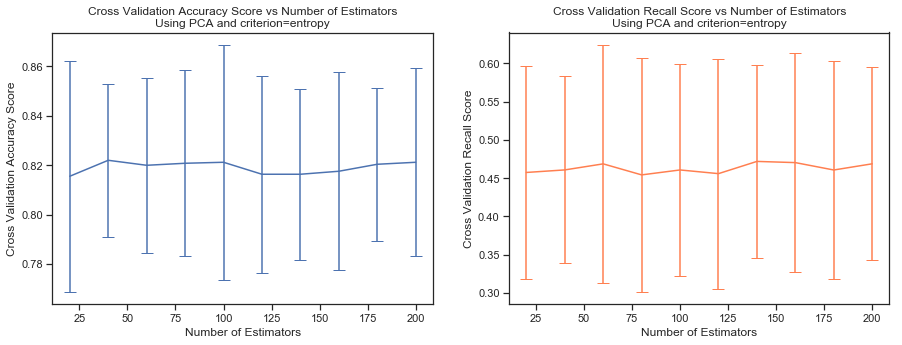

The maximum mean cross validation accuracy score is 0.8219684602324671


In [134]:
# pca, criterion = entropy

X = df_pca
params = {'criterion':'entropy'}
values = [i for i in range(20,201,20)]
using = 'Using PCA and criterion=entropy'
rf_plot_cvs_recall(X, params, values, using)

No. Now, both the cross validation accuracy and recall scores are lower. Let's try with a different criterion for branching. 

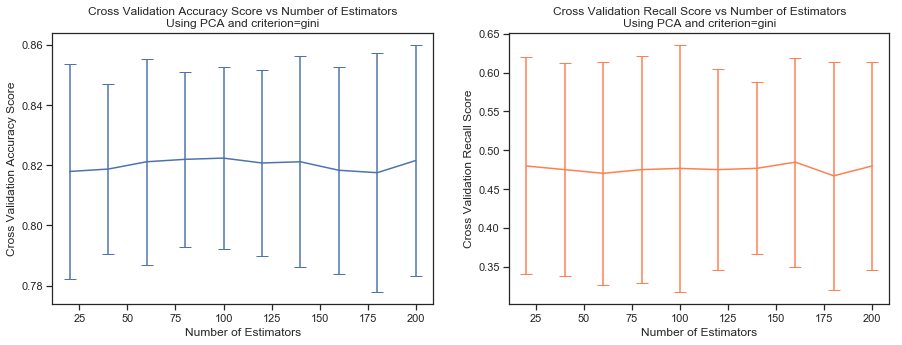

The maximum mean cross validation accuracy score is 0.8223765835183492


In [135]:
# pca, criterion = gini

X = df_pca
params = {'criterion':'gini'}
values = [i for i in range(20,201,20)]
using = 'Using PCA and criterion=gini'
rf_plot_cvs_recall(X, params, values, using)

No, using PCA with gini impurity does not beat our winner.

After inspecting all these plots, we notice that the number of estimators (i.e. trees in the random forest) does not seem to effect the accuracy or recall of the cross validation folds much at all. Also when using all the features, we achieve mean accuracy scores of roughly 84%. This is slightly higher than KNN. The recall scores are also higher when using all the features. We are up to 50%. 

Let's use all features, gini impurity as our criterion for branching, and 100 estimators. Again, any number of estimators in this range will work. Any small variances in average values or uncertainties of these plots is a result of the randomness of the random forest models. Choosing the number of estimators that corresponds with the maximum accuracy score within one of our plot is fruitless. There will be a different maximum if we run the code again. 

Using this model, let's vary the maximum depth of the trees in the forest.

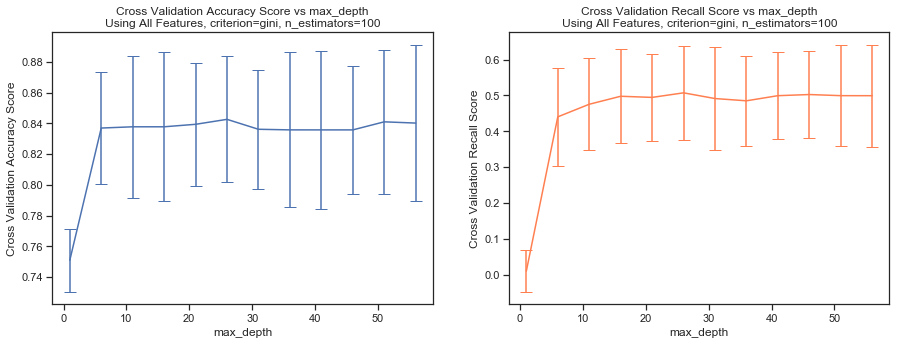

The maximum mean cross validation accuracy score is 0.8425460363066476


In [142]:
# Once again extremely similar code to the KNN plotting function. 
# See that function for details on this code.

X = df_all.drop(['RainTomorrow'], axis=1)
params = {'n_estimators' : 100, 'criterion':'gini'}
values = [i for i in range(1,60,5)]
using = 'Using All Features, criterion=gini, n_estimators=100'
xtitle = 'max_depth'


mean_scores = []
sigma2_scores = []
mean_recalls = []
sigma2_recalls = []
recall = make_scorer(recall_score)

Y = df_all['RainTomorrow']

for value in values: 
    rfc = ensemble.RandomForestClassifier(max_depth=value, **params)
    cross_score = cross_val_score(rfc, X, Y, cv=10)
    mean_scores.append(cross_score.mean())
    sigma2_scores.append(cross_score.std() * 2)

    recall_ = cross_val_score(rfc, X, Y, cv=10, scoring=recall)
    mean_recalls.append(recall_.mean())
    sigma2_recalls.append(recall_.std() * 2)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.errorbar(values, mean_scores, yerr = sigma2_scores, capsize=6)
plt.title('Cross Validation Accuracy Score vs max_depth\n' + str(using))
plt.xlabel('max_depth')
plt.ylabel('Cross Validation Accuracy Score')

plt.subplot(1, 2, 2)    
plt.errorbar(values, mean_recalls, yerr = sigma2_recalls, capsize=6, color='coral')
plt.title('Cross Validation Recall Score vs max_depth\n' + str(using))
plt.xlabel('max_depth')
plt.ylabel('Cross Validation Recall Score')
plt.show()

print('The maximum mean cross validation accuracy score is ' + str(max(mean_scores)))

As long as we have a max depth of at least 10 or so, we are okay. The default of sci-kit learn's random forest is to allow the trees to branch until the leaves are pure. Let's just use that default setting.

Now let's vary max_features. The maximum number of features each tree can choose from.

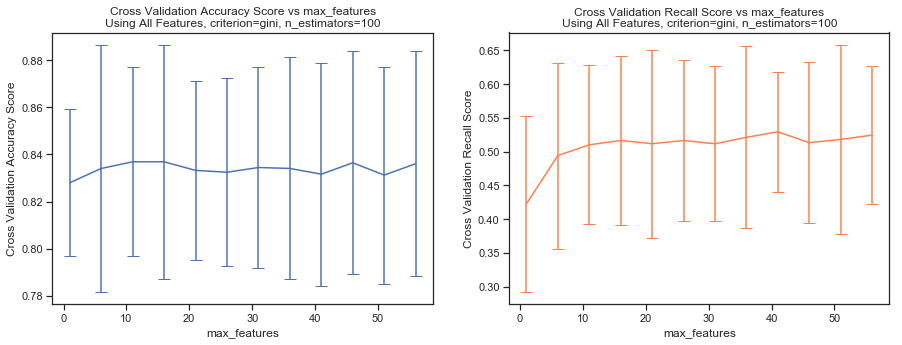

The maximum mean cross validation accuracy score is 0.8368992425231815


In [143]:
## See KNN ploting function for code comments.

X = df_all.drop(['RainTomorrow'], axis=1)
params = {'n_estimators' : 100, 'criterion':'gini'}
values = [i for i in range(1,60,5)]
using = 'Using All Features, criterion=gini, n_estimators=100'
xtitle = 'max_depth'


mean_scores = []
sigma2_scores = []
mean_recalls = []
sigma2_recalls = []
recall = make_scorer(recall_score)

Y = df_all['RainTomorrow']

for value in values: 
    rfc = ensemble.RandomForestClassifier(max_features=value, **params)
    cross_score = cross_val_score(rfc, X, Y, cv=10)
    mean_scores.append(cross_score.mean())
    sigma2_scores.append(cross_score.std() * 2)

    recall_ = cross_val_score(rfc, X, Y, cv=10, scoring=recall)
    mean_recalls.append(recall_.mean())
    sigma2_recalls.append(recall_.std() * 2)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.errorbar(values, mean_scores, yerr = sigma2_scores, capsize=6)
plt.title('Cross Validation Accuracy Score vs max_features\n' + str(using))
plt.xlabel('max_features')
plt.ylabel('Cross Validation Accuracy Score')

plt.subplot(1, 2, 2)    
plt.errorbar(values, mean_recalls, yerr = sigma2_recalls, capsize=6, color='coral')
plt.title('Cross Validation Recall Score vs max_features\n' + str(using))
plt.xlabel('max_features')
plt.ylabel('Cross Validation Recall Score')
plt.show()

print('The maximum mean cross validation accuracy score is ' + str(max(mean_scores)))

The default of sklearn's random forest is to use the square root of the number of features. For us, that would be about 8. It looks like if we let this parameter be a little larger, we will have a higher recall score with a similar accuracy score. Let's use max_features = 15. 

Finally, let's try varying the weight of each class. We have a minority class, so giving that class more weight may help our model. 

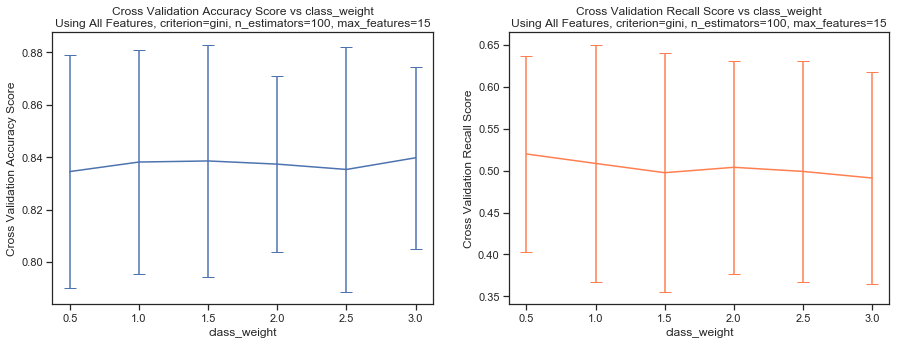

The maximum mean cross validation accuracy score is 0.8397299856340604


In [146]:
X = df_all.drop(['RainTomorrow'], axis=1)
params = {'n_estimators':100, 'criterion':'gini', 'max_features':15}
values = [.5, 1, 1.5, 2, 2.5, 3]
using = 'Using All Features, criterion=gini, n_estimators=100, max_features=15'
xtitle = 'Weight of Minority Class'


mean_scores = []
sigma2_scores = []
mean_recalls = []
sigma2_recalls = []
recall = make_scorer(recall_score)

Y = df_all['RainTomorrow']

for value in values: 
    rfc = ensemble.RandomForestClassifier(class_weight = {0:1, 1:value}, **params)
    cross_score = cross_val_score(rfc, X, Y, cv=10)
    mean_scores.append(cross_score.mean())
    sigma2_scores.append(cross_score.std() * 2)

    recall_ = cross_val_score(rfc, X, Y, cv=10, scoring=recall)
    mean_recalls.append(recall_.mean())
    sigma2_recalls.append(recall_.std() * 2)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.errorbar(values, mean_scores, yerr = sigma2_scores, capsize=6)
plt.title('Cross Validation Accuracy Score vs class_weight\n' + str(using))
plt.xlabel('class_weight')
plt.ylabel('Cross Validation Accuracy Score')

plt.subplot(1, 2, 2)    
plt.errorbar(values, mean_recalls, yerr = sigma2_recalls, capsize=6, color='coral')
plt.title('Cross Validation Recall Score vs class_weight\n' + str(using))
plt.xlabel('class_weight')
plt.ylabel('Cross Validation Recall Score')
plt.show()

print('The maximum mean cross validation accuracy score is ' + str(max(mean_scores)))


There seems to be no noticable benefit of changing the weight attributed to the minority class. We will leave this parameter to be its default value of 1. 

Alright, we have our winning random forest:

All features, branching criterion = gini impurity, 100 estimators, and a maximum of 15 features for each tree to choose from. 

Next Logistic Regression:

# Logistic Regression

We will now explore how logistic regression models perform with our dataset. First, let's evaluate our three datasets, while varying the regularization. 

In [47]:
# Defining our function which makes our plots

def lr_plot_cvs_recall(x, params, values, using):

    """ 
    Takes in four parameters and outputs two plots related to the Logistic Regression Model. 
    One of cross validation accuracy scores vs 'C', and the other showing 
    the recall scores vs 'C'. The parameter 'C' determines how much the regularization will 
    affect our model. When 'C' is very large, there is approximately no regularization. When
    'C' is small, regularization affects the models predictions strongly. 

    x: the dataframe of input features
    params: the parameters other than n_estimators for this model
    values: a list of values for 'C' to be equal to 
    using: a portion of the title of the plots usually begining with the word "Using"

    returns: a plot of cross validation accuracy scores vs number of estimators with errorbars,
    and a plot of cross validation recall scores vs number of estimators with errorbars

    """
   
    ## see KNN plotting function for comments on code. It is incredibly similar. 

    mean_scores = []
    sigma2_scores = []
    mean_recalls = []
    sigma2_recalls = []
    recall = make_scorer(recall_score)
    
    Y = df_all['RainTomorrow']
    
    for value in values: 
        lr = LogisticRegression(C=value, **params)
        cross_score = cross_val_score(lr, X, Y, cv=10)
        mean_scores.append(cross_score.mean())
        sigma2_scores.append(cross_score.std()*2)

        recall_ = cross_val_score(lr, x, Y, cv=10, scoring=recall)
        mean_recalls.append(recall_.mean())
        sigma2_recalls.append(recall_.std() * 2)

    plt.figure(figsize=(15,5))

    plt.subplot(1, 2, 1)
    pyplot.xscale('log')
    plt.errorbar(values, mean_scores, yerr = sigma2_scores, capsize=6)
    plt.title('Cross Validation Accuracy Score vs \'C\' Value\n' + str(using))
    plt.xlabel('\'C\' Value')
    plt.ylabel('Cross Validation Accuracy Score')

    plt.subplot(1, 2, 2)
    pyplot.xscale('log')
    plt.errorbar(values, mean_recalls, yerr = sigma2_recalls, capsize=6, color='coral')
    plt.title('Cross Validation Recall Score vs \'C\' Value\n' + str(using))
    plt.xlabel('\'C\' Value')
    plt.ylabel('Cross Validation Recall Score')
    plt.show()
    
    print('The maximum mean cross validation accuracy score is ' + str(max(mean_scores)))

## Logistic Regressing Using All Features

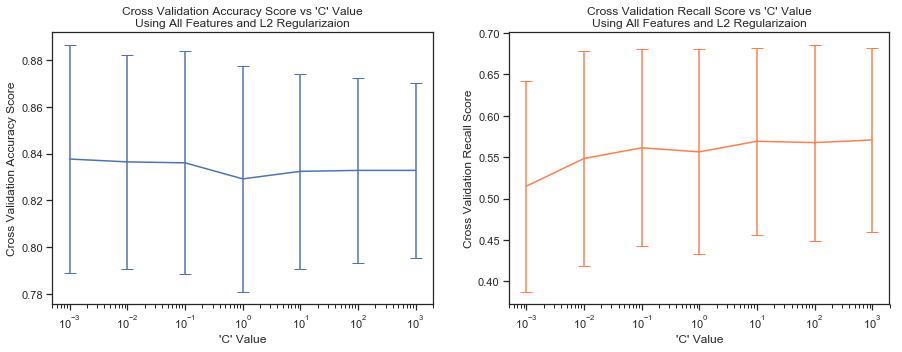

The maximum mean cross validation accuracy score is 0.8377154890949459


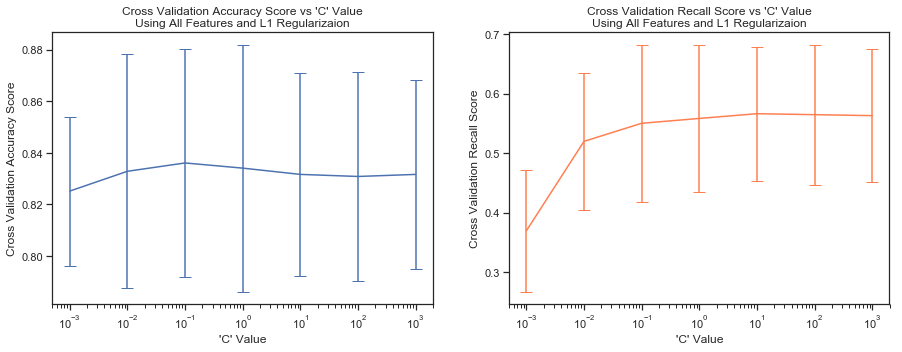

The maximum mean cross validation accuracy score is 0.836086260937704


In [42]:
X = df_all.drop(['RainTomorrow'], axis=1)
params = {'penalty' : 'l2'}
values = [.001, .01, .1, 1, 10, 100, 1000]
using = 'Using All Features and L2 Regularizaion'
lr_plot_cvs_recall(X, params, values, using)


X = df_all.drop(['RainTomorrow'], axis=1)
params = {'penalty' : 'l1'}
values = [.001, .01, .1, 1, 10, 100, 1000]
using = 'Using All Features and L1 Regularizaion'
lr_plot_cvs_recall(X, params, values, using)

This is a tough call. We first and foremost want to have the highest cross validation accuracy score. Because of that, lets go with C = 0.1. It is very difficult to decide which regularization to use. We would use the recall scoer as a tie-breaker, but both recall scores are very similar. Either works well. Let's compare them to our other logistic regression models. 

## Logistic Regression Using Significant Features

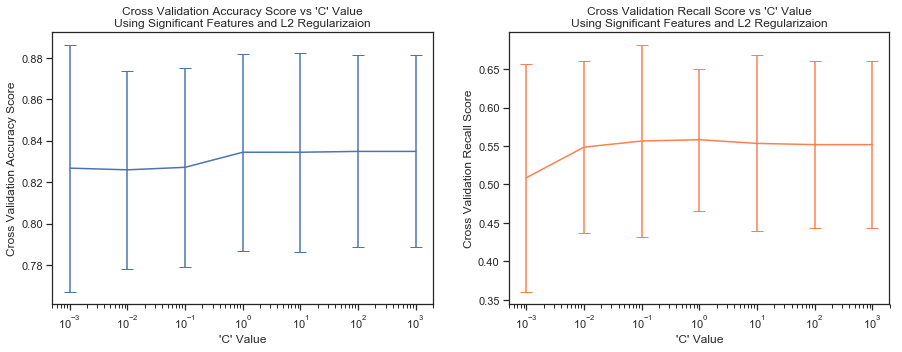

The maximum mean cross validation accuracy score is 0.8348847459840669


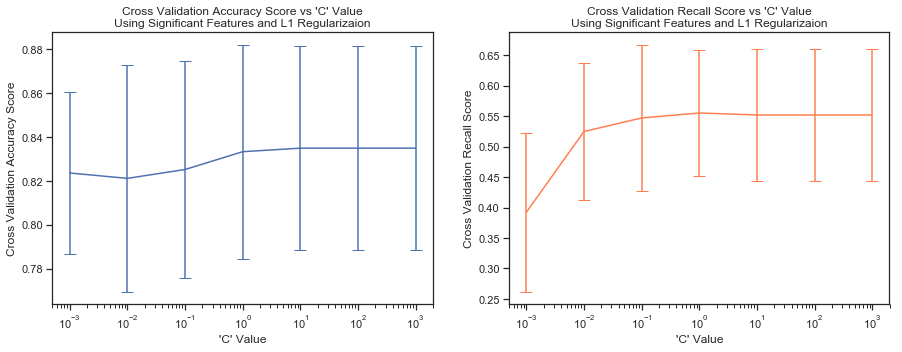

The maximum mean cross validation accuracy score is 0.8348847459840669


In [48]:
X = df_sign.drop(['RainTomorrow'], axis=1)
params = {'penalty' : 'l2'}
values = [.001, .01, .1, 1, 10, 100, 1000]
using = 'Using Significant Features and L2 Regularizaion'
lr_plot_cvs_recall(X, params, values, using)


X = df_sign.drop(['RainTomorrow'], axis=1)
params = {'penalty' : 'l1'}
values = [.001, .01, .1, 1, 10, 100, 1000]
using = 'Using Significant Features and L1 Regularizaion'
lr_plot_cvs_recall(X, params, values, using)

This is also a tough call. Using a C value of 1 looks best for either L2 or L1 regularization, but this is not much noticeably better or worse than using all the features. Let's try with the 5 principal components of PCA. 

## Logistic Regression Using PCA

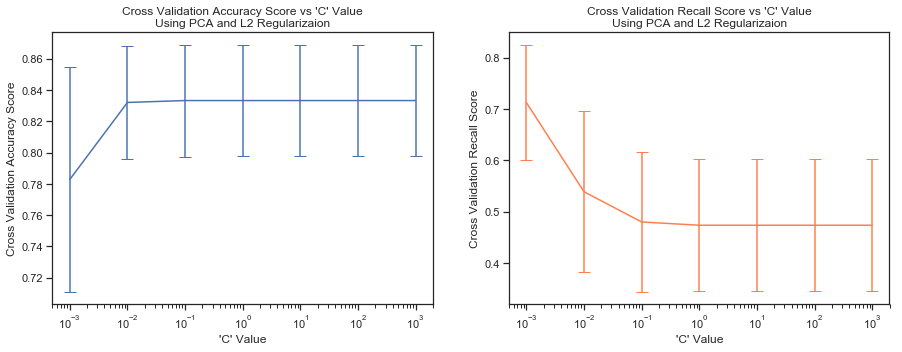

The maximum mean cross validation accuracy score is 0.8332751077445474


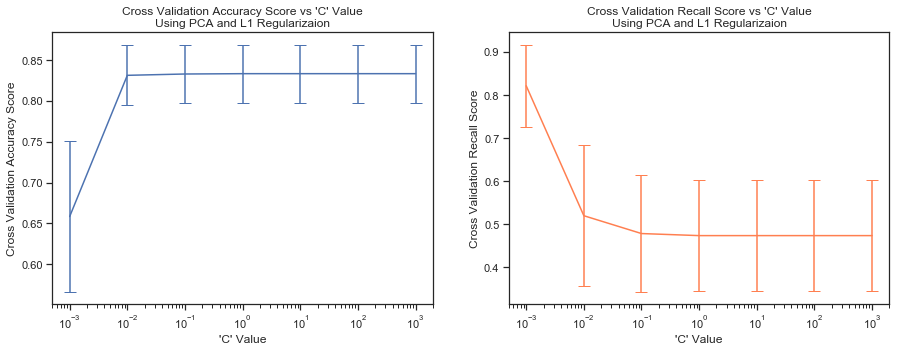

The maximum mean cross validation accuracy score is 0.8332751077445474


In [41]:
X = df_pca
params = {'penalty' : 'l2'}
values = [.001, .01, .1, 1, 10, 100, 1000]
using = 'Using PCA and L2 Regularizaion'
lr_plot_cvs_recall(X, params, values, using)

X = df_pca
params = {'penalty' : 'l1'}
values = [.001, .01, .1, 1, 10, 100, 1000]
using = 'Using PCA and L1 Regularizaion'
lr_plot_cvs_recall(X, params, values, using)

Well, we certainly don't want to use a 'C' value of 0.001. With that C value, we have the highest recall score we have seen, but the cross validation accuracy score is quite low. Any 'C' value greater than 0.01 is fine here, but our recall scores are not as high as with the previous conditions. 

There is not clear winner here. Let's use significant features with L2 regularization and a 'C' value of 1. This gives us a strong cross validation accuracy score and a high recall score with smaller errorbars. 

NOTE: I have checked to make sure there is no error in determining the maximum mean cross validation accuracy score for each trial. The values are the same for both trials with  significant features and PCA. The values other than the maximum are indeed different. When we use a large value of 'C' the regularization vanishes. Notice a 'C' value of 1000 yields the like maxima. 

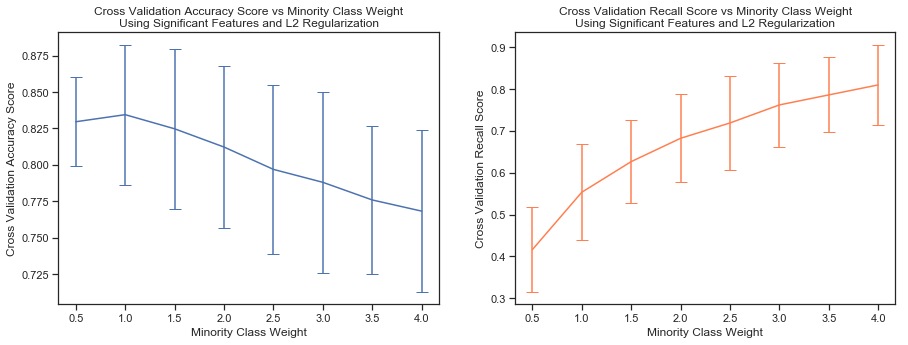

In [59]:
## see KNN ploting function for comments on code.

x = df_sign.drop(['RainTomorrow'], axis=1)
values = [.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]
mean_scores = []
sigma2_scores = []
mean_recalls = []
sigma2_recalls = []
recall = make_scorer(recall_score)

Y = df_all['RainTomorrow']

for value in values: 
    lr = LogisticRegression(class_weight={0:1, 1:value}, C=10, penalty='l2')
    cross_score = cross_val_score(lr, X, Y, cv=10)
    mean_scores.append(cross_score.mean())
    sigma2_scores.append(cross_score.std()*2)

    recall_ = cross_val_score(lr, x, Y, cv=10, scoring=recall)
    mean_recalls.append(recall_.mean())
    sigma2_recalls.append(recall_.std() * 2)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.errorbar(values, mean_scores, yerr = sigma2_scores, capsize=6)
plt.title('Cross Validation Accuracy Score vs Minority Class Weight\nUsing Significant Features and L2 Regularization')
plt.xlabel('Minority Class Weight')
plt.ylabel('Cross Validation Accuracy Score')

plt.subplot(1, 2, 2)

plt.errorbar(values, mean_recalls, yerr = sigma2_recalls, capsize=6, color='coral')
plt.title('Cross Validation Recall Score vs Minority Class Weight\nUsing Significant Features and L2 Regularization')
plt.xlabel('Minority Class Weight')
plt.ylabel('Cross Validation Recall Score')
plt.show()


By using class_weight, we were able to achieve a recall of nearly 80%, but our accuracy dropped significantly. We are aiming to find the model with the highest accuracy, thus we will stick with the default weight of 1. 

Now, we are onto the next model type, support vector machines. 

# Support Vector Machines

## Testing different kernels, using all features

In [64]:
from sklearn.svm import SVC
# different kernel to test.
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
# creating the scorer for cross validation recall. 
recall = make_scorer(recall_score)
# our input and output variables.
X = df_all.drop('RainTomorrow', 1)
Y = df_all['RainTomorrow']

# looping through the different kernels
for kern in kernels:
    # initializing our support vector machine
    svclf = SVC(kernel=kern)
    #evaluating the accuracy of each fold of cross validation
    cross_val_accuracy = cross_val_score(svclf, X, Y, cv=10)
    print('stats for {} kernel:'.format(kern))
    print('cross validation accuracy score = '+ str(round(cross_val_accuracy.mean(),6)) +' +/- ' + str(round(cross_val_accuracy.std()*2,6)))

    #evaluating the recall of each fold of cross validation
    cross_val_recall_ = cross_val_score(svclf, X, Y, cv=10, scoring=recall)
    print('cross validation recall score = '+ str(round(cross_val_recall_.mean(),6)) +' +/- ' + str(round(cross_val_recall_.std()*2,6)))
        


stats for linear kernel:
cross validation accuracy score = 0.835293 +/- 0.04343
cross validation recall score = 0.564567 +/- 0.12439
stats for poly kernel:
cross validation accuracy score = 0.835691 +/- 0.046718
cross validation recall score = 0.553277 +/- 0.135265
stats for rbf kernel:
cross validation accuracy score = 0.773123 +/- 0.023777
cross validation recall score = 0.135612 +/- 0.071998
stats for sigmoid kernel:
cross validation accuracy score = 0.746874 +/- 0.002768
cross validation recall score = 0.0 +/- 0.0


## Using significant features

In [65]:

# different kernel to test.
kernels = ['linear', 'rbf', 'sigmoid']
# creating the scorer for cross validation recall. 
recall = make_scorer(recall_score)
# our input and output variables.
X = df_sign.drop('RainTomorrow', 1)
Y = df_sign['RainTomorrow']

# looping through the different kernels
for kern in kernels:
    # initializing our support vector machine
    svclf = SVC(kernel=kern)
    #evaluating the accuracy of each fold of cross validation
    cross_val_accuracy = cross_val_score(svclf, X, Y, cv=10)
    print('stats for {} kernel:'.format(kern))
    print('cross validation accuracy score = '+ str(round(cross_val_accuracy.mean(),6)) +' +/- ' + str(round(cross_val_accuracy.std()*2,6)))

    #evaluating the recall of each fold of cross validation
    cross_val_recall_ = cross_val_score(svclf, X, Y, cv=10, scoring=recall)
    print('cross validation recall score = '+ str(round(cross_val_recall_.mean(),6)) +' +/- ' + str(round(cross_val_recall_.std()*2,6)))
        


stats for linear kernel:
cross validation accuracy score = 0.83246 +/- 0.037496
cross validation recall score = 0.507066 +/- 0.10185
stats for rbf kernel:
cross validation accuracy score = 0.761403 +/- 0.018981
cross validation recall score = 0.090835 +/- 0.059955
stats for sigmoid kernel:
cross validation accuracy score = 0.746874 +/- 0.002768
cross validation recall score = 0.0 +/- 0.0


## Using PCA

In [67]:
# different kernel to test.
kernels = ['linear', 'rbf', 'sigmoid']
# creating the scorer for cross validation recall. 
recall = make_scorer(recall_score)
# our input and output variables.
X = df_pca
Y = df_sign['RainTomorrow']

# looping through the different kernels
for kern in kernels:
    # initializing our support vector machine
    svclf = SVC(kernel=kern)
    scores =  cross_validate(svclf, X, Y, cv=10, scoring=('accuracy', 'recall'))
    cross_val_accuracy = scores['test_accuracy']
    print('stats for {} kernel:'.format(kern))
    print('cross validation accuracy score = '+ str(round(cross_val_accuracy.mean(),6)) +' +/- ' + str(round(cross_val_accuracy.std()*2,6)))

    #evaluating the recall of each fold of cross validation
    cross_val_recall_ = scores['test_recall']
    print('cross validation recall score = '+ str(round(cross_val_recall_.mean(),6)) +' +/- ' + str(round(cross_val_recall_.std()*2,6)))

stats for linear kernel:
cross validation accuracy score = 0.831649 +/- 0.038625
cross validation recall score = 0.430415 +/- 0.161396
stats for rbf kernel:
cross validation accuracy score = 0.746471 +/- 0.004054
cross validation recall score = 0.0 +/- 0.0
stats for sigmoid kernel:
cross validation accuracy score = 0.638702 +/- 0.075148
cross validation recall score = 0.280876 +/- 0.13502


NOTE: We did not use polynomial kernels for significant features or PCA because those models were taking an incredibly long time to run. They never completed and the computer would not respond to interupting the kernel when they were running. Using all the features with a polynomial kernel took a while, but it did finish. 

## Support Vector Machine Conclusion
Using all the features and a linear kernel is gives us a strong accuracy and recall score. Let's use this. 


# Gradient Boosting Classifier

Here, we will define our function for plotting.

In [34]:
def gb_plot_cvs_recall(x, params, values, using):
    
    """ 
    Takes in four parameters and outputs two plots related to the Gradient Boosting Classifier. 
    One of cross validation accuracy scores vs number of estimators, and the other showing 
    the recall scores vs number of estimators.

    x: the dataframe of input features
    params: the parameters other than n_estimators for this model
    values: a list of values for n_estimators to be equal to 
    using: a portion of the title of the plots usually begining with the word "Using"

    returns: a plot of cross validation accuracy scores vs n_estimators with errorbars,
    and a plot of cross validation recall scores vs n_estimators with errorbars

    """
    
    # Again, look at the KNN plotting function for comments on this code.
    
    mean_scores = []
    sigma2_scores = []
    mean_recalls = []
    sigma2_recalls = []
    recall = make_scorer(recall_score)
    
    Y = df_all['RainTomorrow']
    
    for value in values: 
        gbc = GradientBoostingClassifier(n_estimators = value, **params)
        scores =  cross_validate(gbc, X, Y, cv=10, scoring=('accuracy', 'recall'))
        cross_score = scores['test_accuracy']
        mean_scores.append(cross_score.mean())
        sigma2_scores.append(cross_score.std()*2)

        recall_ = scores['test_recall']
        mean_recalls.append(recall_.mean())
        sigma2_recalls.append(recall_.std()*2)

    plt.figure(figsize=(15,5))

    plt.subplot(1, 2, 1)
    plt.errorbar(values, mean_scores, yerr = sigma2_scores, capsize=6)
    plt.title('Cross Validation Accuracy Score vs Number of Estimators\n' + str(using))
    plt.xlabel('Number of Estimators')
    plt.ylabel('Cross Validation Accuracy Score')

    plt.subplot(1, 2, 2)
    plt.errorbar(values, mean_recalls, yerr = sigma2_recalls, capsize=6, color='coral')
    plt.title('Cross Validation Recall Score vs Number of Estimators\n' + str(using))
    plt.xlabel('Number of Estimators')
    plt.ylabel('Cross Validation Recall Score')
    plt.show()
    
    print('The maximum mean cross validation accuracy score is ' + str(max(mean_scores)))

### Gradient Boosting Classifier using all features

We will try different combinations of the loss function to be optimized and the learning rate. We will use the learning rates of 0.05, 0.1, and 0.2.

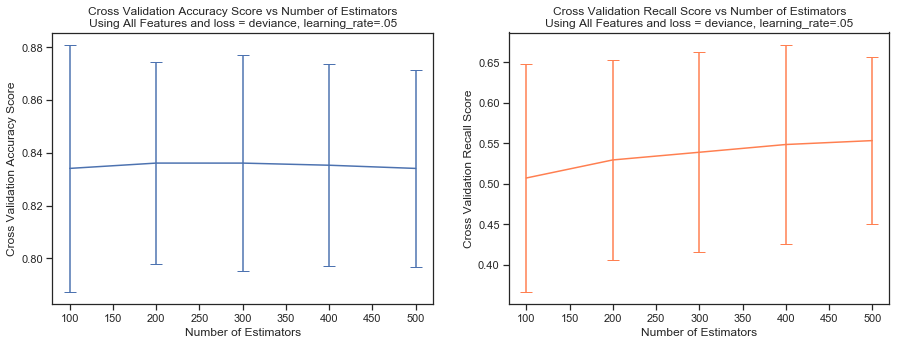

The maximum mean cross validation accuracy score is 0.83607973096513


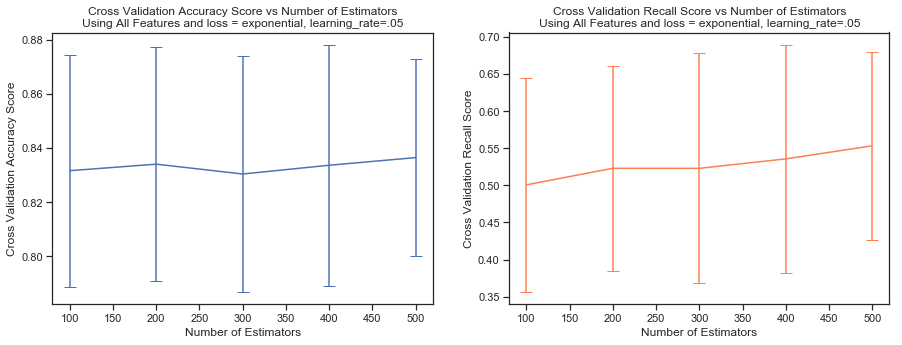

The maximum mean cross validation accuracy score is 0.8364829567715816


In [41]:
# learning rate of .05
# loss=deviance
X = df_all.drop(['RainTomorrow'], axis=1)
params = {'loss':'deviance', 'learning_rate':.05}
values = [100,200,300,400,500]
using = 'Using All Features, loss=deviance, learning_rate=.05'
gb_plot_cvs_recall(X, params, values, using)


# loss=expondential
X = df_all.drop(['RainTomorrow'], axis=1)
params = {'loss':'exponential', 'learning_rate':.05}
values = [100,200,300,400,500]
using = 'Using All Features, loss=exponential, learning_rate=.05'
gb_plot_cvs_recall(X, params, values, using)



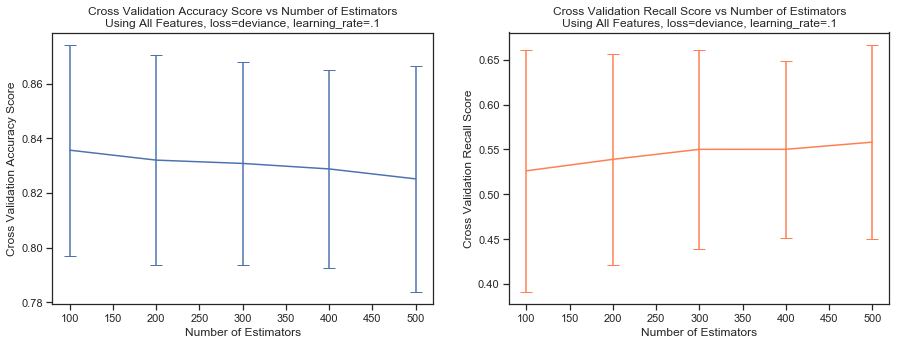

The maximum mean cross validation accuracy score is 0.8356781376518219


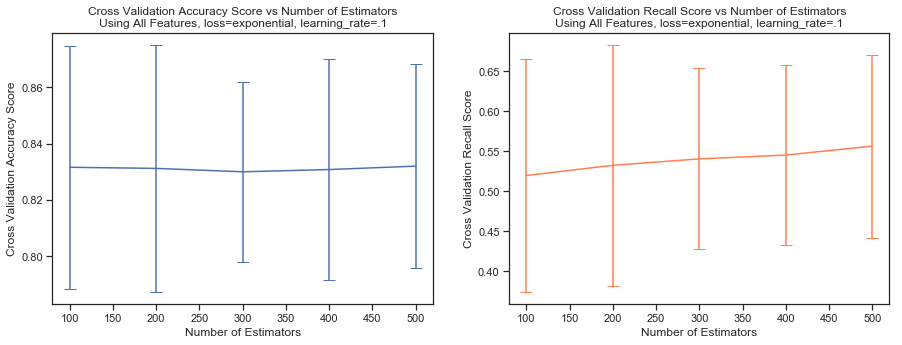

The maximum mean cross validation accuracy score is 0.8320409429280395


In [49]:
# learning rate = .1
#loss=deviance
X = df_all.drop(['RainTomorrow'], axis=1)
params = {'loss':'deviance', 'learning_rate':.1}
values = [100,200,300,400,500]
using = 'Using All Features, loss=deviance, learning_rate=.1'
gb_plot_cvs_recall(X, params, values, using)

#loss=exponential
X = df_all.drop(['RainTomorrow'], axis=1)
params = {'loss':'exponential', 'learning_rate':.1}
values = [100,200,300,400,500]
using = 'Using All Features, loss=exponential, learning_rate=.1'
gb_plot_cvs_recall(X, params, values, using)

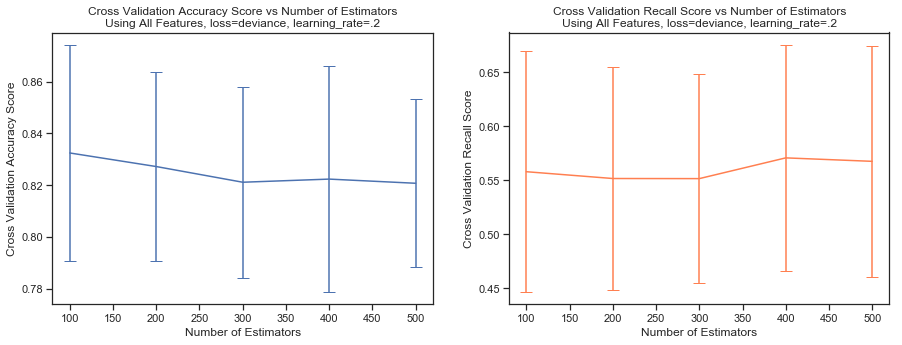

The maximum mean cross validation accuracy score is 0.8324490662139219


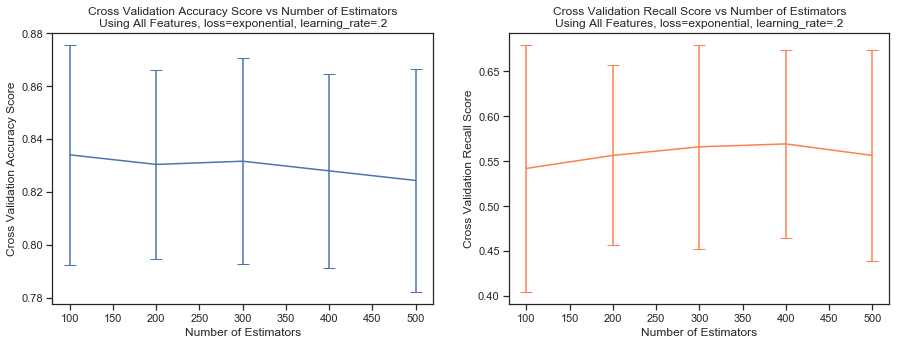

The maximum mean cross validation accuracy score is 0.8340538069740108


In [45]:
# learning rate of .2
# loss=deviance
X = df_all.drop(['RainTomorrow'], axis=1)
params = {'loss':'deviance', 'learning_rate':.2}
values = [100,200,300,400,500]
using = 'Using All Features, loss=deviance, learning_rate=.2'
gb_plot_cvs_recall(X, params, values, using)

# loss=expential
X = df_all.drop(['RainTomorrow'], axis=1)
params = {'loss':'exponential', 'learning_rate':.2}
values = [100,200,300,400,500]
using = 'Using All Features, loss=exponential, learning_rate=.2'
gb_plot_cvs_recall(X, params, values, using)

Of all these options with all features, nothing jumps out as obviously best. Also, this model is inherently random, so there are small changes to the outcome each time the model is run. Let's use loss=exponential, learning_rate=0.1, and 300 estimators as our best gradient boosting classifier with all features. These parameters yield a strong accuracy and recall score as well as a smaller uncertainty in both scores. 

### Gradient Boosting Classifier with Significant Features

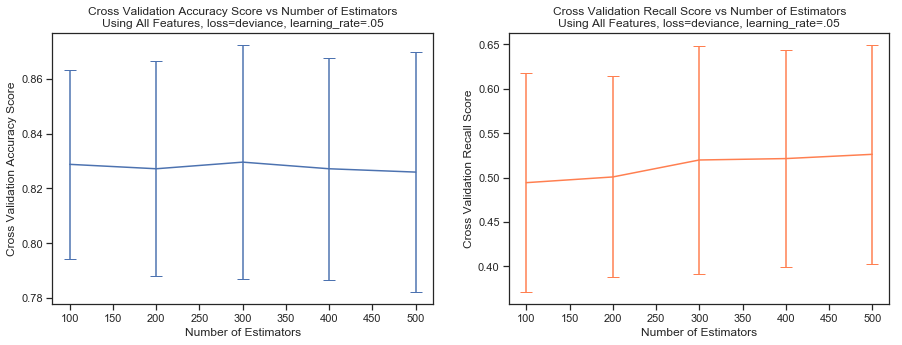

The maximum mean cross validation accuracy score is 0.8296281180619041


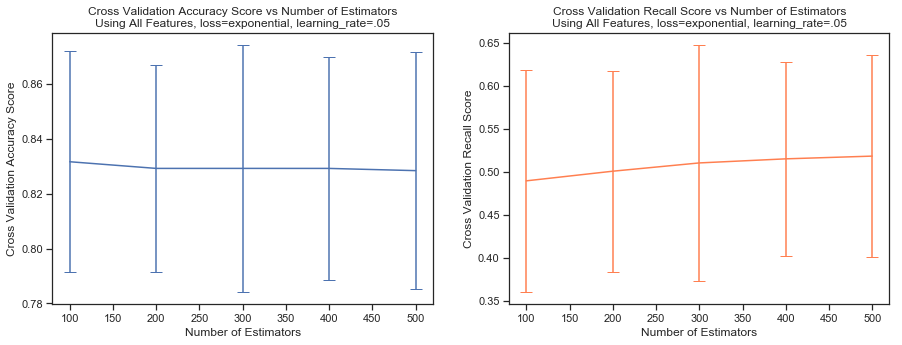

The maximum mean cross validation accuracy score is 0.8316573070393105


In [51]:
# learning rate of .05
# loss=deviance
X = df_sign.drop(['RainTomorrow'], axis=1)
params = {'loss':'deviance', 'learning_rate':.05}
values = [100,200,300,400,500]
using = 'Using All Features, loss=deviance, learning_rate=.05'
gb_plot_cvs_recall(X, params, values, using)


# loss=expondential
X = df_sign.drop(['RainTomorrow'], axis=1)
params = {'loss':'exponential', 'learning_rate':.05}
values = [100,200,300,400,500]
using = 'Using All Features, loss=exponential, learning_rate=.05'
gb_plot_cvs_recall(X, params, values, using)

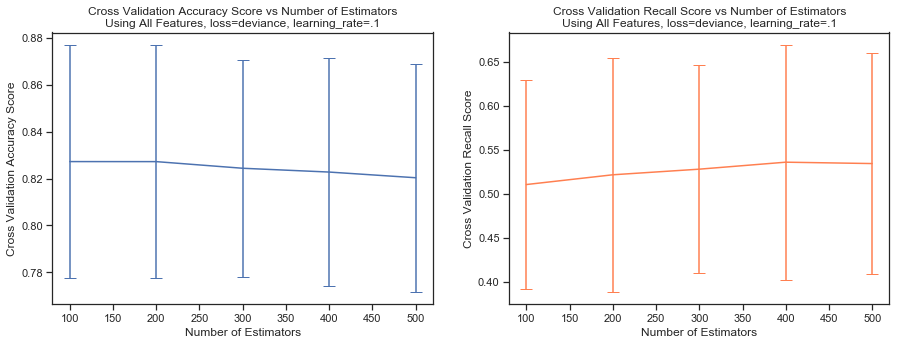

The maximum mean cross validation accuracy score is 0.8272185581820557


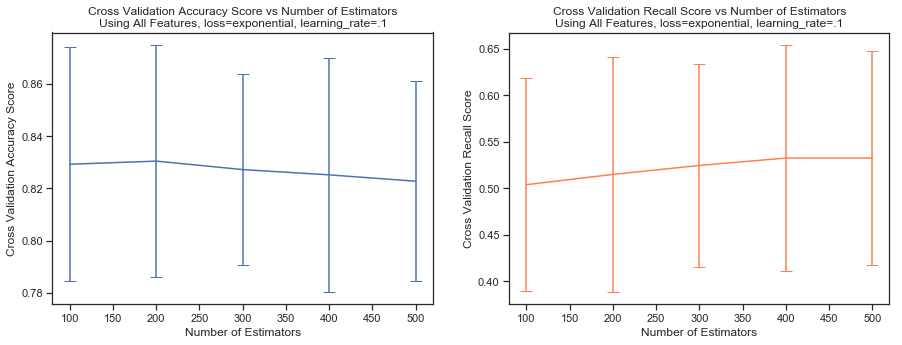

The maximum mean cross validation accuracy score is 0.8304296721953767


In [52]:
# learning rate = .1
#loss=deviance
X = df_sign.drop(['RainTomorrow'], axis=1)
params = {'loss':'deviance', 'learning_rate':.1}
values = [100,200,300,400,500]
using = 'Using All Features, loss=deviance, learning_rate=.1'
gb_plot_cvs_recall(X, params, values, using)

#loss=exponential
X = df_sign.drop(['RainTomorrow'], axis=1)
params = {'loss':'exponential', 'learning_rate':.1}
values = [100,200,300,400,500]
using = 'Using All Features, loss=exponential, learning_rate=.1'
gb_plot_cvs_recall(X, params, values, using)

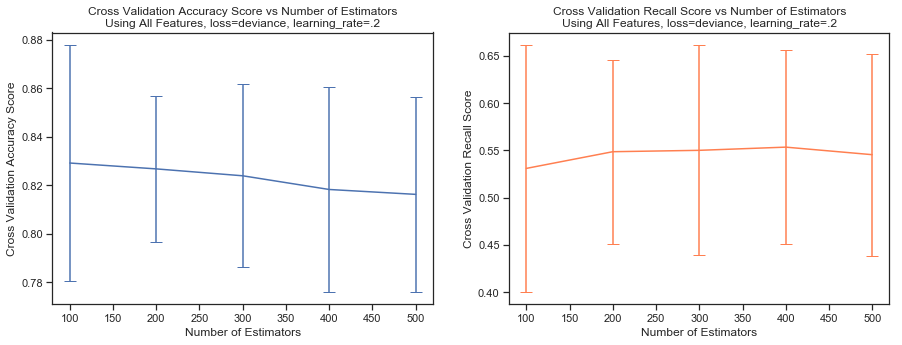

The maximum mean cross validation accuracy score is 0.8292118323103044


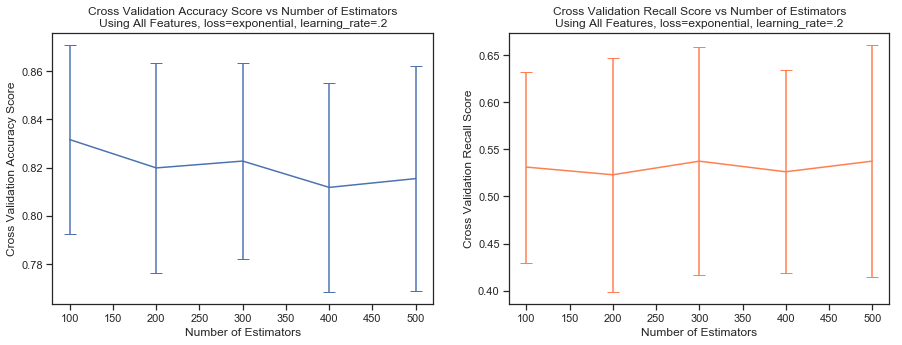

The maximum mean cross validation accuracy score is 0.8316573070393105


In [53]:
# learning rate of .2
# loss=deviance
X = df_sign.drop(['RainTomorrow'], axis=1)
params = {'loss':'deviance', 'learning_rate':.2}
values = [100,200,300,400,500]
using = 'Using All Features, loss=deviance, learning_rate=.2'
gb_plot_cvs_recall(X, params, values, using)

# loss=expential
X = df_sign.drop(['RainTomorrow'], axis=1)
params = {'loss':'exponential', 'learning_rate':.2}
values = [100,200,300,400,500]
using = 'Using All Features, loss=exponential, learning_rate=.2'
gb_plot_cvs_recall(X, params, values, using)

Each of these significant feature models is slightly worse than our best gradient boosting classifier with df_all. These all have lower accuracy and recall scores.

### Gradient Boosting with PCA

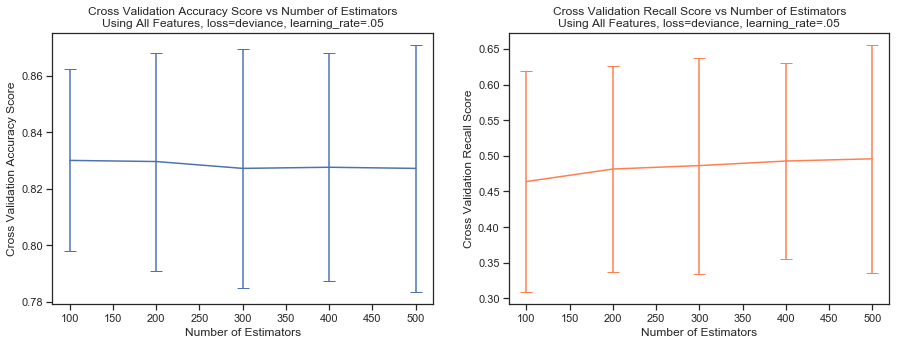

The maximum mean cross validation accuracy score is 0.8300460363066474


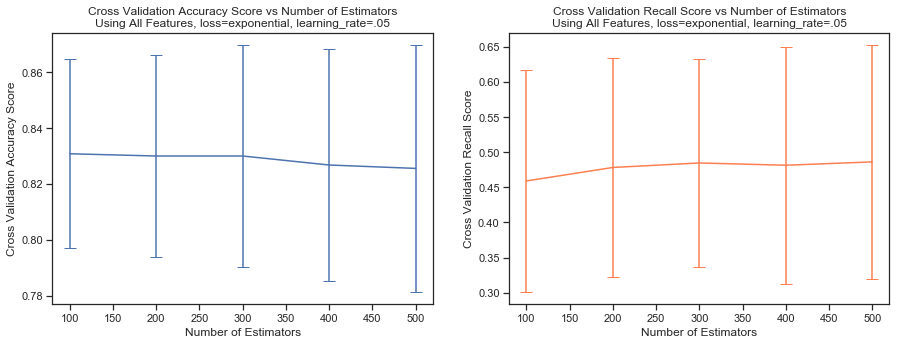

The maximum mean cross validation accuracy score is 0.830855752905838


In [55]:
# learning rate of .05
# loss=deviance
X = df_pca
params = {'loss':'deviance', 'learning_rate':.05}
values = [100,200,300,400,500]
using = 'Using All Features, loss=deviance, learning_rate=.05'
gb_plot_cvs_recall(X, params, values, using)


# loss=expondential
X = df_pca
params = {'loss':'exponential', 'learning_rate':.05}
values = [100,200,300,400,500]
using = 'Using All Features, loss=exponential, learning_rate=.05'
gb_plot_cvs_recall(X, params, values, using)

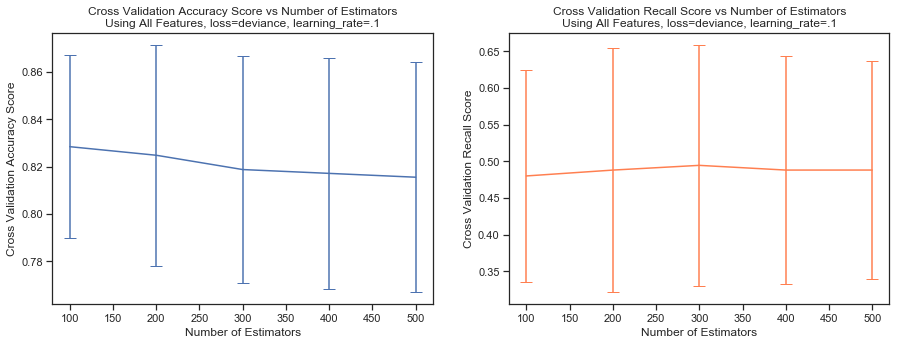

The maximum mean cross validation accuracy score is 0.8284347655739847


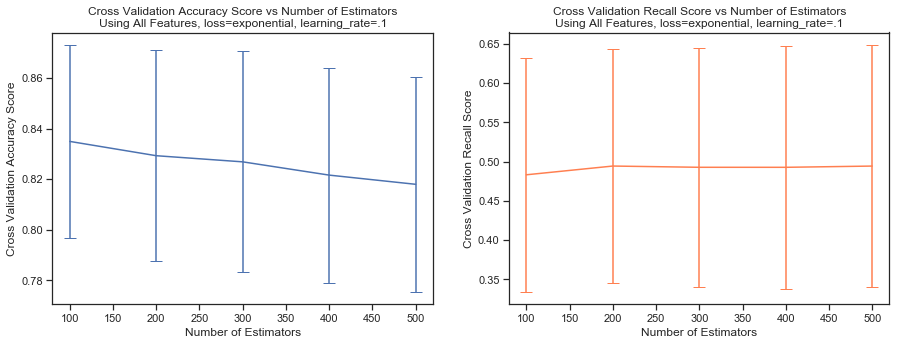

The maximum mean cross validation accuracy score is 0.8348961734360716


In [56]:
# learning rate = .1
#loss=deviance
X = df_pca
params = {'loss':'deviance', 'learning_rate':.1}
values = [100,200,300,400,500]
using = 'Using All Features, loss=deviance, learning_rate=.1'
gb_plot_cvs_recall(X, params, values, using)

#loss=exponential
X = df_pca
params = {'loss':'exponential', 'learning_rate':.1}
values = [100,200,300,400,500]
using = 'Using All Features, loss=exponential, learning_rate=.1'
gb_plot_cvs_recall(X, params, values, using)

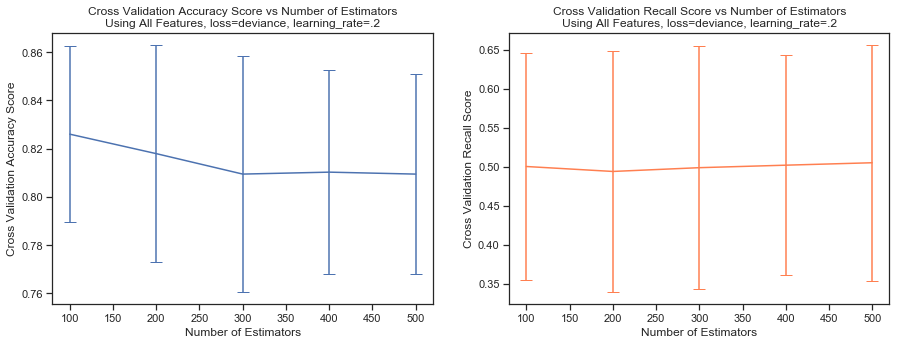

The maximum mean cross validation accuracy score is 0.8260072482695573


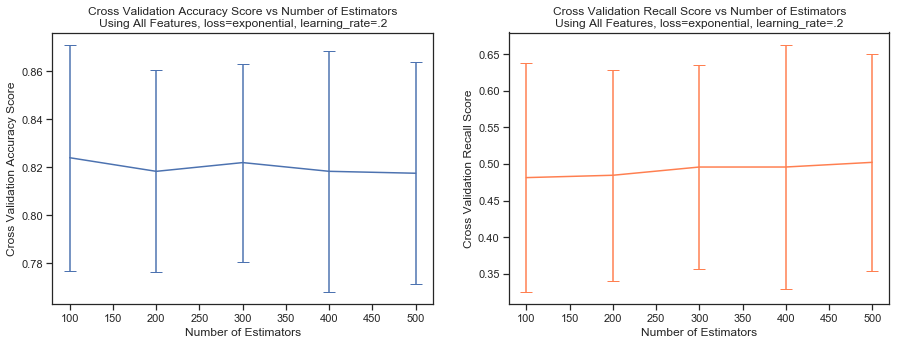

The maximum mean cross validation accuracy score is 0.8239976492098734


In [57]:
# learning rate of .2
# loss=deviance
X = df_pca
params = {'loss':'deviance', 'learning_rate':.2}
values = [100,200,300,400,500]
using = 'Using All Features, loss=deviance, learning_rate=.2'
gb_plot_cvs_recall(X, params, values, using)

# loss=expential
X = df_pca
params = {'loss':'exponential', 'learning_rate':.2}
values = [100,200,300,400,500]
using = 'Using All Features, loss=exponential, learning_rate=.2'
gb_plot_cvs_recall(X, params, values, using)

Well, most of these PCA models have a good cross validation accuracy score, but they don't have strong cross validation recall scores when compared to using all features. Thus, the gradient boosting champion remains using all features, with loss=exponential, learning_rate=0.1, and 300 estimators.  

Let's check a few more learning rates to be sure we have chosen a good one for our best model.

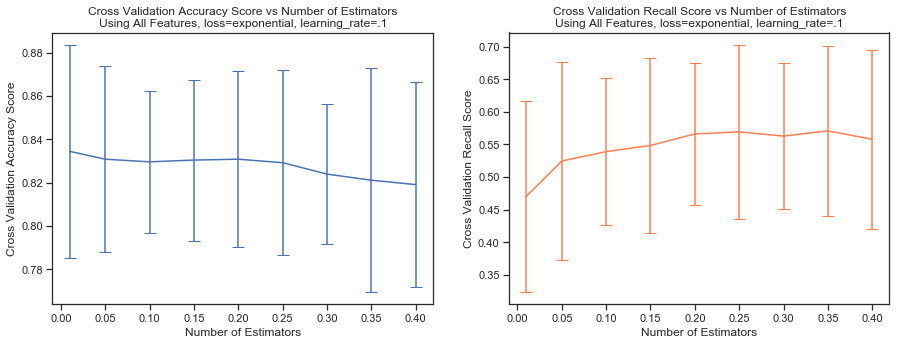

The maximum mean cross validation accuracy score is 0.8344635627530366


In [60]:
#loss=exponential

# see previous similar code for comments.

X = df_all.drop(['RainTomorrow'], axis=1)
params = {'loss':'exponential', 'n_estimators':300}
values = [.01, .05, .1, .15, .2, .25, .3, .35, .4 ]
using = 'Using All Features, loss=exponential, learning_rate=.1'


mean_scores = []
sigma2_scores = []
mean_recalls = []
sigma2_recalls = []
recall = make_scorer(recall_score)

X = df_all.drop(['RainTomorrow'], axis=1)
Y = df_all['RainTomorrow']

for value in values: 
    gbc = GradientBoostingClassifier(learning_rate = value, **params)
    scores =  cross_validate(gbc, X, Y, cv=10, scoring=('accuracy', 'recall'))
    cross_score = scores['test_accuracy']
    mean_scores.append(cross_score.mean())
    sigma2_scores.append(cross_score.std()*2)

    recall_ = scores['test_recall']
    mean_recalls.append(recall_.mean())
    sigma2_recalls.append(recall_.std()*2)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.errorbar(values, mean_scores, yerr = sigma2_scores, capsize=6)
plt.title('Cross Validation Accuracy Score vs Number of Estimators\n' + str(using))
plt.xlabel('Number of Estimators')
plt.ylabel('Cross Validation Accuracy Score')

plt.subplot(1, 2, 2)
plt.errorbar(values, mean_recalls, yerr = sigma2_recalls, capsize=6, color='coral')
plt.title('Cross Validation Recall Score vs Number of Estimators\n' + str(using))
plt.xlabel('Number of Estimators')
plt.ylabel('Cross Validation Recall Score')
plt.show()

print('The maximum mean cross validation accuracy score is ' + str(max(mean_scores)))

Yes, choosing learning_rate = 0.1 is a good choice. We have a high accuracy score and low uncertainty. 

Let's also see if a subsample fraction of less than the default of one is benificial. 

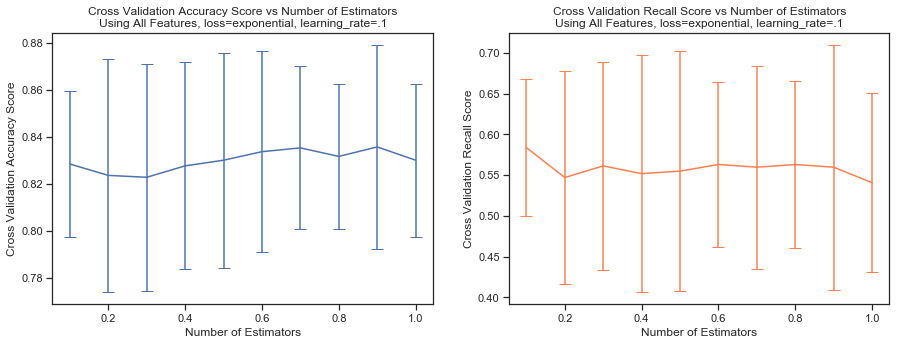

The maximum mean cross validation accuracy score is 0.8356781376518219


In [64]:
#loss=exponential

# see pervious code comments.

X = df_all.drop(['RainTomorrow'], axis=1)
params = {'loss':'exponential', 'n_estimators':300, 'learning_rate':.1}
values = [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
using = 'Using All Features, loss=exponential, learning_rate=.1'


mean_scores = []
sigma2_scores = []
mean_recalls = []
sigma2_recalls = []
recall = make_scorer(recall_score)

X = df_all.drop(['RainTomorrow'], axis=1)
Y = df_all['RainTomorrow']

for value in values: 
    gbc = GradientBoostingClassifier(subsample = value, **params)
    scores =  cross_validate(gbc, X, Y, cv=10, scoring=('accuracy', 'recall'))
    cross_score = scores['test_accuracy']
    mean_scores.append(cross_score.mean())
    sigma2_scores.append(cross_score.std()*2)

    recall_ = scores['test_recall']
    mean_recalls.append(recall_.mean())
    sigma2_recalls.append(recall_.std()*2)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.errorbar(values, mean_scores, yerr = sigma2_scores, capsize=6)
plt.title('Cross Validation Accuracy Score vs Number of Estimators\n' + str(using))
plt.xlabel('Number of Estimators')
plt.ylabel('Cross Validation Accuracy Score')

plt.subplot(1, 2, 2)
plt.errorbar(values, mean_recalls, yerr = sigma2_recalls, capsize=6, color='coral')
plt.title('Cross Validation Recall Score vs Number of Estimators\n' + str(using))
plt.xlabel('Number of Estimators')
plt.ylabel('Cross Validation Recall Score')
plt.show()

print('The maximum mean cross validation accuracy score is ' + str(max(mean_scores)))

No, a subsampling rate of 1 is sufficient. After running this code twice, we see the small fluctuations in the output change. We will stick to using a subsample fraction of 1, that is using all of the features in our dataset when fitting the individual trees rather than a fraction of them.

## Gradient Boosting Classifier Conclusion

Our best gradient boosting classifier remains using all features, with loss=exponential, learning_rate=0.1, and 300 estimators.

# Final Evaluation of the Five Best Models

We will now compare the best classifier of each type of model. We will first evaluate which model is the best via cross validation. Then we will see how it performs compared to the others on the testing data we set aside at the begining of this treatment. 

In [243]:
# All 5 models with the best parameters we found
# KNN Winning Model winner: Using all features scaled, weighing by distance, and using 30 neighbors.
knn = KNeighborsClassifier(n_neighbors = 30, weights = 'distance')

# Random Forest Winner: All features, the branching criterion is gini impurity, 100 estimators, 
# and a maximum of 15 features for each tree to choose from.
rf = ensemble.RandomForestClassifier(n_estimators = 100, criterion = 'gini', max_features = 15)

# Logistic Regression Winner: Significant features with L2 regularization and a 'C' value of 1. 
lr = LogisticRegression(C = 0.1, penalty = 'l2')

# Support Vector Machine Winner: Using all the features and a linear kernel
svc = SVC(kernel = 'linear')

# Gradient Boosting Winner: Using all features, with loss=exponential, learning_rate=0.1, and 300 estimators.
gb = GradientBoostingClassifier(n_estimators = 300, loss = 'exponential', learning_rate=0.1)

# the models in the order we have been using
models = [knn, rf, lr, svc, gb]

# the models' names.
model_names = ['Nearest Neighbors', 
              'Random Forest',
              'Logistic Regression',
              'Support Vector Machine',
              'Gradient Boosting']

# the models' whose winner uses all features
models_all_features = [rf, svc, gb]

# the models' whose winner uses the significant features
models_sign_features = [knn, lr]

# Initializing the mean and the uncertanity in each of the accuracy and recall 
# cross validation scores for each model.
mean_scores = []
sigma2_scores = []
mean_recalls = []
sigma2_recalls = []
recall = make_scorer(recall_score)

# Creating the input dataframes and target.
X_all = df_all.drop('RainTomorrow', 1)
X_sign = df_sign.drop('RainTomorrow', 1)
Y = df_all['RainTomorrow']

# evaluating each model that uses all features
for model in models_all_features: 
    scores =  cross_validate(model, X_all, Y, cv=10, scoring=('accuracy', 'recall'))
    cross_score = scores['test_accuracy']
    mean_scores.append(cross_score.mean())
    sigma2_scores.append(cross_score.std()*2)

    recall_ = scores['test_recall']
    mean_recalls.append(recall_.mean())
    sigma2_recalls.append(recall_.std()*2)

# evaluating each model that uses significant features
for model in models_sign_features: 
    scores =  cross_validate(model, X_sign, Y, cv=10, scoring=('accuracy', 'recall'))
    cross_score = scores['test_accuracy']
    mean_scores.append(cross_score.mean())
    sigma2_scores.append(cross_score.std()*2)

    recall_ = scores['test_recall']
    mean_recalls.append(recall_.mean())
    sigma2_recalls.append(recall_.std()*2)

# putting the lists back into the order we have used throughout this process 
# We have been extremely careful to do this correctly
# after running loop the order will be those using df_all followed by those using df_sign
#[rf, svc, gb, knn, lr]
#[0,  1,   2,  3,   4]

# we want
# [knn, rf, lr, svc, gb] thus...
# [3,   0,  4,  1,   2]

# reordering these lists
eval_order = [3, 0, 4, 1, 2] 
mean_scores = [mean_scores[i] for i in eval_order]
sigma2_scores = [sigma2_scores[i] for i in eval_order]
mean_recalls = [mean_recalls[i] for i in eval_order]
sigma2_recalls = [sigma2_recalls[i] for i in eval_order]

Nearest Neighbors statistics: 
 Cross Validation Accuracy Score: 0.828825 +/- 0.035566 
 Cross Validation Recall Score: 0.457578 +/- 0.121631 


Random Forest statistics: 
 Cross Validation Accuracy Score: 0.836091 +/- 0.043644 
 Cross Validation Recall Score: 0.505428 +/- 0.120849 


Logistic Regression statistics: 
 Cross Validation Accuracy Score: 0.827199 +/- 0.048157 
 Cross Validation Recall Score: 0.556503 +/- 0.125392 


Support Vector Machine statistics: 
 Cross Validation Accuracy Score: 0.835293 +/- 0.04343 
 Cross Validation Recall Score: 0.564567 +/- 0.12439 


Gradient Boosting statistics: 
 Cross Validation Accuracy Score: 0.830028 +/- 0.032526 
 Cross Validation Recall Score: 0.540527 +/- 0.109609 




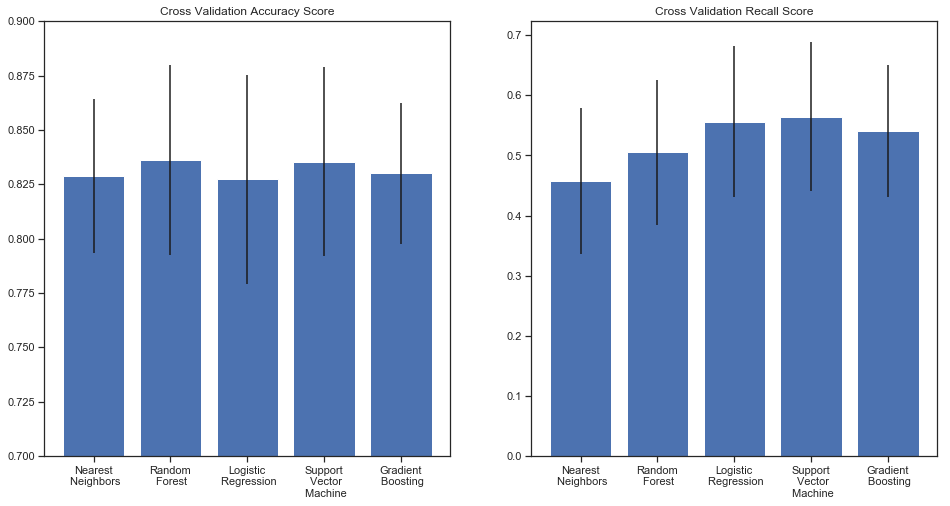

In [244]:
# creating a list of model names to use on our horizontal axes
model_names_for_plot = ['Nearest\n Neighbors', 
              'Random\n Forest',
              'Logistic\n Regression',
              'Support\n Vector\n Machine',
              'Gradient\n Boosting']

# Creating a loop to print our findings in text form.
for i in range(0,5):
    print('{} statistics: \n Cross Validation Accuracy Score: {} +/- {} \n Cross Validation Recall Score: {} +/- {} \n\n'.format(
        model_names[i], round(mean_scores[i],6), round(sigma2_scores[i],6), round(mean_recalls[i],6), round(sigma2_recalls[i],6)))

# Plotting our findings.
plt.figure(figsize=(16, 8))

# Plotting our cross validation accuracy scores. Note the y-axis will not start at 0 but 0.7
ax1 = plt.subplot(1, 2, 1)
ax1.set_ylim(ymin=0.7, ymax=0.9)
plt.bar(x = model_names_for_plot, height = mean_scores, yerr=sigma2_scores)
plt.title('Cross Validation Accuracy Score')

# Plotting our cross validation recall scores.
plt.subplot(1, 2, 2)
plt.bar(x=model_names_for_plot, height = mean_recalls, yerr=sigma2_recalls)
plt.title('Cross Validation Recall Score')
plt.show()

## Best Model Conclusion

After performing cross validation on each top model, we have the above results. Our support vector classifier and our random forest have similar accuracy scores. With our uncertainty in both measurements, we can't pick a champion based soly off these accuracy scores. Thankfully, we have our recall scores to use in the case of a tie. Our support vector machine has the highest recall score of all. The second highest recall score goes to our logistic regression model, but that model has our lowest accuracy score. Thus, we have found our champion. It is our support vector machine! 

It is also worth noting that our Gradient Boosting Classifier's accuracy has the smallest uncertainty. If we were looking for the most consistent model, then we would choose this model.

## Our Winner: Support Vector Machine

Let's now see how well it predicts whether or not it will rain the next day in our testing dataset. 

As a reminder, our testing dataset is composed of the instances of our original dataset with years 2011 and 2014. 

In [92]:
# Our training data
X = df_all.drop('RainTomorrow', 1)
Y = df_all['RainTomorrow']

# Our testing data which we have withheld from the evaluation process.  
X_test = df_all_test.drop(['RainTomorrow'], axis=1)
Y_test_true = df_all_test['RainTomorrow']

# Fitting our model
svc = SVC(kernel = 'linear')
svc.fit(X, Y)
Y_test_pred = svc.predict(X_test)

# gethering the confusion_matrix
cf = confusion_matrix(Y_test_true, Y_test_pred)
tn, fp, fn, tp = confusion_matrix(Y_test_true, Y_test_pred).ravel()
accuracy = (tp + tn)/(tn + fp + fn + tp)
recall = tp/(tp +fn)
specificity = tn/(fp + tn)
print('Our winning model\'s confusion matrix:\n', cf)
print('\nAccuracy: {}%'.format(round(accuracy*100, 3)))
print('\nRecall (Sensitivity): {}%'.format(round(recall*100, 3)))
print('\nSpecificity: {}%'.format(round(specificity*100, 3)))




Our winning model's confusion matrix:
 [[462  39]
 [ 77 100]]

Accuracy: 82.891%

Recall (Sensitivity): 56.497%

Specificity: 92.216%


## Model's Performance on Testing Data

When applied to the testing data, our model has an accuracy of roughly 82.9%. This seems reasonable since we observed cross validation accuracy scores in this range during our model evaluation process. This means our model makes a correct prediction in roughly 83% of all instances. 

We have a recall score of 56.5%. Thus, out of all the instances with rain tomorrow, we correctly predict 56.6% of them. We see this reflected in our confusion matrix. There are 177 instances with rain tomorrow, and we correctly predict 100 of those instances. While this may seem like a low success rate, let's remember that our goal was to first and foremost find the model with the highest accuracy score. We did see some models that had a higher recall score, but they were very lousy with regards to accuracy. They would predict rain tomorrow far too often and this lead to a low accuracy score and many Type I Errors (false alarms).

Our model is very talented at predicting no rain tomorrow. Of all the instances with no rain tomorrow, we correctly predict 92.2% of them. It is rare that we incorrectly predict an instance of no rain tomorrow. Out of all the 501 instances with no rain tomorrow we incorrectly predict only 39 of them.  

Let's now shift our focus to determining which features of our data set are most important in predicting whether or not it will rain tomorrow in Sydney. 

# Feature Importance

Unfortunately, our winning model, a support vector classifier, does not convey feature importance. Of the models that we have used, our random forest classifier and our gradient boosting classifier are able to provide information on features importance. This is because both models use combinations of trees, which search for the best features to use as branching criteria. Roughly speaking, the more trees in the forest that use a given feature to inform its branching, the more important that feature. 

We may also use a single desision tree to find the most important feature. Let's create a decision tree that will using Shannon Entropy as its branching criterion. It will also use the dataframe with all of our features. 

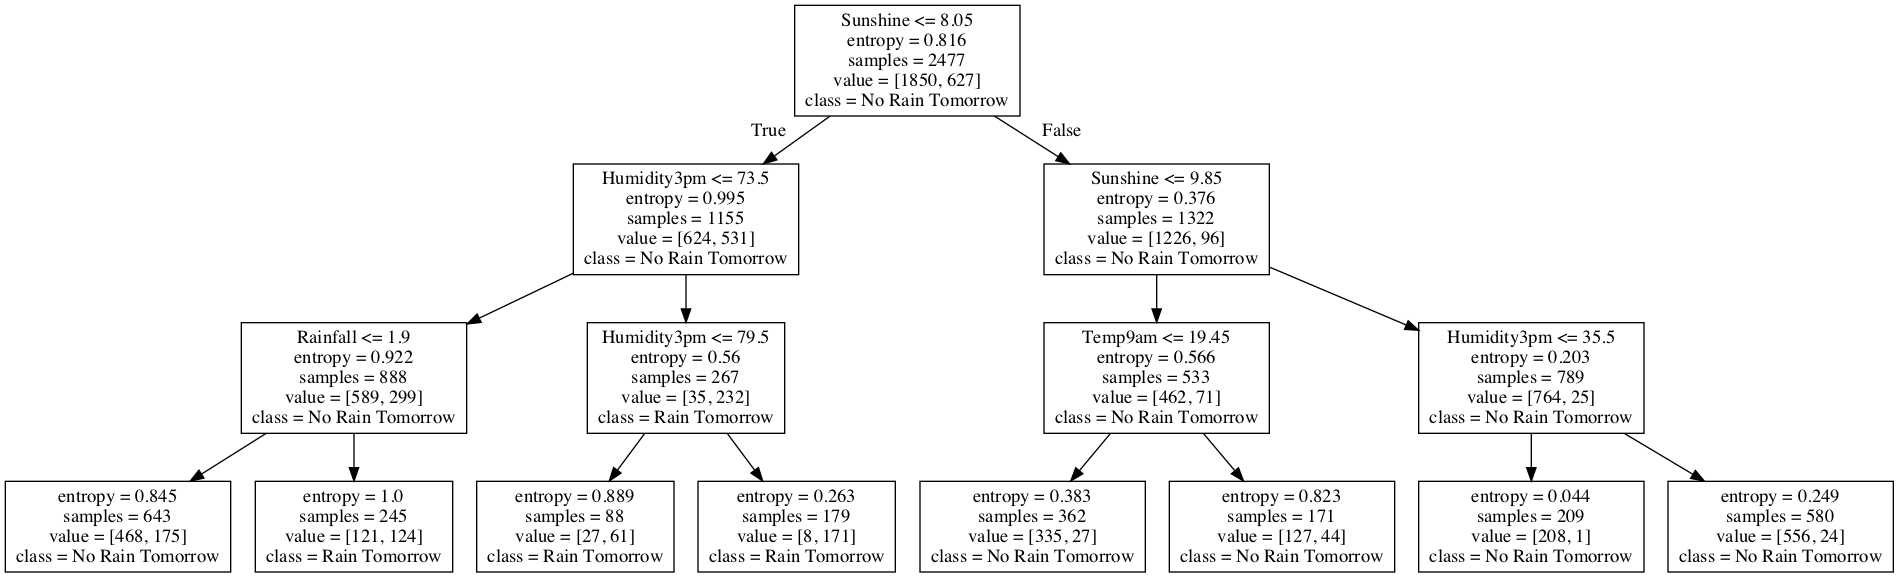

In [102]:
# This is the model we'll be using.
from sklearn import tree

# A convenience for displaying visualizations.
from IPython.display import Image

# Packages for rendering our tree.
import pydotplus
import graphviz

# Initialize and train our tree.
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    #max_features=3,
    max_depth=3,
    #random_state = 1337
)

# Selecting our input and output features. 
X = df_all.drop('RainTomorrow', 1)
Y = df_all['RainTomorrow']
decision_tree.fit(X, Y)

# Render our tree.
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=df_all.columns.drop(['RainTomorrow'], 1),
    class_names=['No Rain Tomorrow', 'Rain Tomorrow'],
    #filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

As we can see, 'Sunshine' is the most important feature. Our tree is using it to determine its first branching criterion - if sunshine is less that or equal to 8.05 move to one node, otherwise move to the other node. Our model found that this branching rule was most effective at reducing our overall entropy from the parent node to the two child nodes. Our tree also finds 'Humidity3pm' to be of importance. It uses 'Humidity3pm' in its decision rule at the next depth.

From this tree, we learn that 'Sunshine', 'Humidity3pm', 'Rainfall', and 'Temp9am' are of high importance for predicting rain. 

Our best random forest can also give us insight about the most important features. 

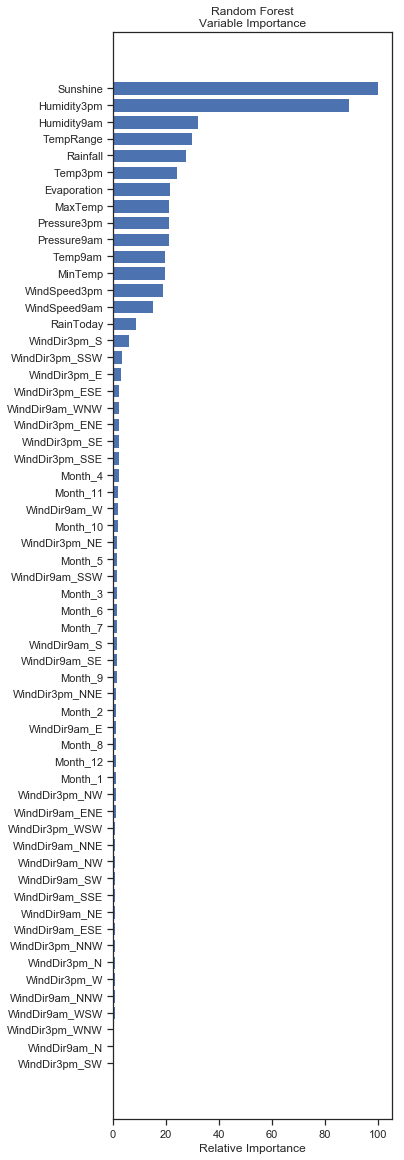

In [132]:
# Our best random forest model
rf = ensemble.RandomForestClassifier(n_estimators = 100, criterion = 'gini', max_features = 15)

# Our training data
X = df_all.drop('RainTomorrow', 1)
Y = df_all['RainTomorrow']

# Fitting our model
rf.fit(X, Y)

# Extracting an array of feature importances
feature_importance = rf.feature_importances_
# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
# Sorting the importances by magnitude and plotting. 
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize = (5,20))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Random Forest\nVariable Importance')
plt.show()

As we can see when using our random forest, our most important feature is also 'Sunshine' followed closely by 'Humidity3pm'. We also see that wind direction and the month do not have a significant impact on our model. 

What does our best gradient boosting model tell us about feature importance?

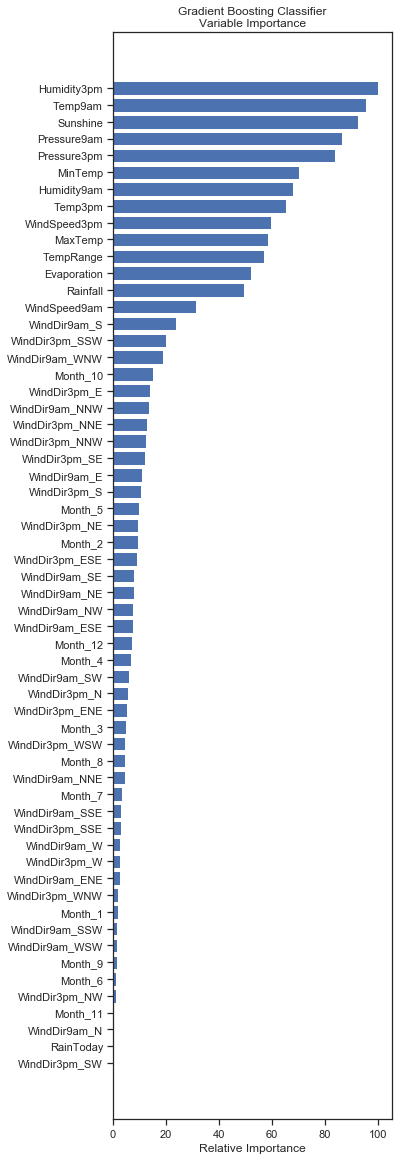

In [130]:
# Our best gradient boosting classifier
gb = GradientBoostingClassifier(n_estimators = 300, loss = 'exponential', learning_rate=0.1)

# Our training data
X = df_all.drop('RainTomorrow', 1)
Y = df_all['RainTomorrow']

# Fitting our model
gb.fit(X, Y)

# Extracting an array of feature importances
feature_importance = gb.feature_importances_
# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
# Sorting the importances by magnitude and plotting. 
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize = (5,20))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Gradient Boosting Classifier\nVariable Importance')
plt.show()

Unlike our random forest, our gradient boosting classifier finds 'Humidity3pm' to be the most important feature, followed by 'Temp9am', and then 'Sunshine'. Again, we see that the month of the year and wind direction are not of importance to this model. Suprisingly, our gradient boosting classifier finds 'RainToday' incredibly unhelpful (it is listed second to last). However, our random forest found it to be of moderate importance. This discrepancy goes to show how the two models, while both constructed with forests of decision trees, work very differently from one another.  

Lastly, we can view feature importance simply by the correlation of each feature with the outcome variable, 'RainTomorrow'. Let's see a plot of that. 

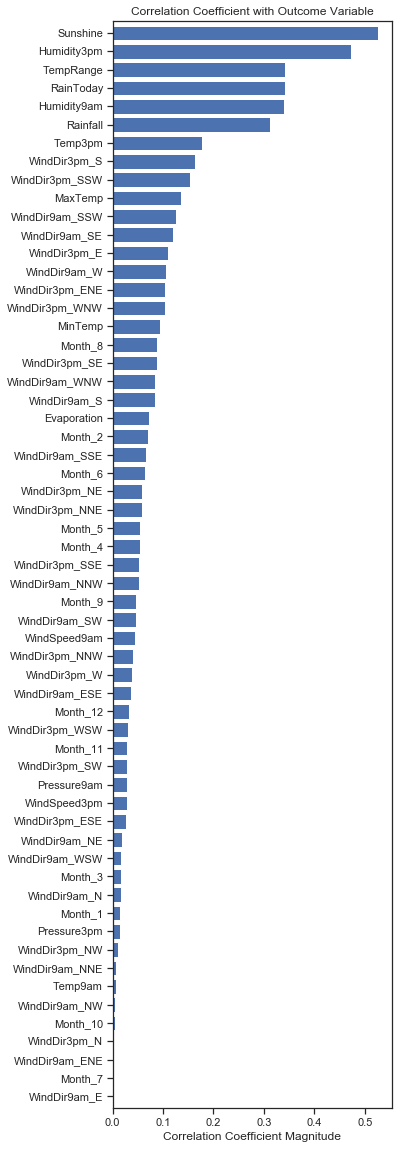

In [165]:
plt.figure(figsize = (5,20))
abs(df_all.corr()['RainTomorrow']).sort_values(ascending=True)[:-1].plot(kind='barh', width=0.8)
plt.title('Correlation Coefficient with Outcome Variable')
plt.xlabel('Correlation Coefficient Magnitude')
plt.show()

As we can see, 'Sunshine' is most correlated with 'RainTomorrow' followed by 'Humidity', 'TempRange', and 'RainToday'. Our choice to create 'TempRange' seems like a good decision. We did of course create this feature because we knew it would have a high correlation with 'RainTomorrow' based on our previous violin plots. It seems funny that 'RainToday' is so highly correlated with 'RainTomorrow', but neither forest model found it very important, especially our gradient boosting model. 

# Final Thoughts

It would be interesting to gather more weather data on Sydney, AUS and see how our model performs. Are we still as accurate in 2018 and 2019? If our performance drops, we could fine-tune our model, making it more general and potentially more accurate. Would we be able to detect any signs of global warming? Our model might perform worse in the future because of the changing environment and perhaps we could gain insight into how the environment is changing via our model.

Throughout this process, we restricted ourselves to the data concerning Sydney, AUS. It would be interesting to see how our classifier performs on other cities. We would not expect it to perform quite as well, but maybe the weather in Sydney is similar to that of another Australian city. By training our model on a different city, we could gain insight into what features are most important in predicting weather in that city. Maybe a completely different model would perform best in another city. For instance, maybe KNN would be best in Melbourne. We could also find a more general model that predicts rain tomorrow in all the Australian cities that we have data on. In that case, we should keep the 'City' feature we dropped at the begining of our treatment. With that model, we could learn more about rain prediction in general, since we would be using a more expansive area of our Earth in training our classifier.  

While our model is no where near as accurate as the weather forcasting models of present day, we did achieved an accuracy of more than 80%. While weather patterns are very complex systems, our knowledge and careful evaluation of supervised learning models allow us to made progress in predicting weather. 

Humans have likely been seeking accurate rain predictions for most of our time on Earth. Now, with the proper data, we can begin to answer this age-old question. After all of our analysis and model evaluation, it is amusing to know that we can correctly inform Sydney locals on whether or not to pack an umbrella four days out of five. 